In [3]:
%%time

# import libraries

from io import StringIO
import itertools
import numpy as np
import pandas as pd
from pandas import Series
from pandas import concat
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (40,10))
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

# start spark sesssion
spark = SparkSession.builder.appName('climateChange').getOrCreate()

# main function
def readFiles (feature):
    
    # convert tuples to string
    def process(tup):
        def convertTuple(tup): 
            str =  ''.join(tup) 
            return str

        # convert tuples to strings and load them into pandas dataframe
        str = convertTuple(tup[0:2]) 
        df = pd.read_csv(StringIO(str), header=None)

        # slicing the output and storing filename in "filename dataframe"
        filename = df[0:1]
        filename = filename.iloc[0][0].replace('txtncols         180','')
        
        # for daily data, the range is -9 to -1
        if(feature == "rainfall" or feature == "maximum-temperature"):
            filename = filename[-9:-1]
        
        # for monthly data, the range is -7 to -1
        elif(feature == "sunshine" or feature == "snow-falling"):
            filename = filename[-7:-1]

        # storing the content of file in "content dataframe"
        content = df[6:]

        counter = 0 
        allValues = 0

        # iterate through all the rows and columns of the file 
        modPandasDF = content.iloc[:,0].str.split(' ',expand=True).replace("-9999",float('NaN'))
        modPandasDF = modPandasDF.astype('float')
        modPandasDF = modPandasDF.values
        xDF = np.nanmean(modPandasDF)
        mean = np.nanmean(xDF)

        return filename, mean
    
    # daily grid data for rainfall
    if(feature == "rainfall" or feature == "maximum-temperature"):
        path = "hdfs:/data/HCP053/climate/gridded-land-obs-daily/grid/"+feature+"/*"
    
    elif(feature == "sunshine" or feature == "snow-falling"):
        path = "hdfs:/data/HCP053/climate/gridded-land-obs-monthly/"+feature+"/*"

    # Get rdd containing one record for each file.
    files_rdd = sc.wholeTextFiles(path, minPartitions = 20)
    print('Number of records (months):', files_rdd.count())

    # map lines to n_words
    records = files_rdd.map(lambda n : process(n))

    # collect the RDD to a list
    llist = records.collect()

    # two arrays
    values = []
    months = []

    # store the filename in months array and its corrosponding value(mean) in values array
    for line in llist:
        values.append(line[1])
        months.append(line[0])

    # converting arrays to dataframes
    valuesdf = pd.DataFrame({'Values':values[:]})
    yearmonthdf = pd.DataFrame({'YearMonth':months[:]})

    # merging two dataframes into one
    finaldf = pd.merge(yearmonthdf, valuesdf, left_index = True, right_index = True)

    # sort the index
    finaldf = finaldf.sort_values('YearMonth')

    # converting first column to integer format
    finaldf['YearMonth'] = finaldf['YearMonth'].astype('int')
    
    # converting first column of daily data from integer to datetime format
    if(feature == "rainfall" or feature == "maximum-temperature"):
        finaldf['YearMonth'] = pd.to_datetime(finaldf['YearMonth'].astype(str), format = '%Y%m%d')
    
    # converting first column of monthly data from integer to datetime format
    elif(feature == "sunshine" or feature == "snow-falling"):
        finaldf['YearMonth'] = pd.to_datetime(finaldf['YearMonth'].astype(str), format = '%Y%m')

    # extracting year and month 
    finaldf['Year'] = finaldf['YearMonth'].dt.year
    finaldf['Month'] = finaldf['YearMonth'].dt.month
    
    return finaldf


# plotting the data as it is from the dataset
def plotTrend (finaldf, feature):
    
    plt.plot(finaldf.YearMonth, finaldf.Values)
    
    if (feature == "rainfall"):
        plt.title('Daily Rainfall in UK (1910 - 2016)')
        plt.ylabel('Rainfall (mm)')
        
    if (feature == "maximum-temperature"):
        plt.title('Daily Max Temperature of UK (1960 - 2016)')
        plt.ylabel('Temperature')

    if(feature == "sunshine"):
        plt.title('Monthly Sunshine in UK (1929 - 2016)')
        plt.ylabel('Number of Hours')
    
    if(feature == "snow-falling"):
        plt.title('Monthly Snowfall in UK (1971 - 2011)')
        plt.ylabel('Number of Days')
        
    plt.xlabel('Date')
    plt.xticks(rotation = 'vertical')
    plt.show()
    
    
# LINE OF BEST FIT to look for any trend in data if present
def getBestFit(finaldf, feature): 
    
    y_values = finaldf['Values']
    
    #create a set of intervals equal to the number of dates
    x_values = np.linspace(0, 1, len(finaldf.loc[:, "Values"]))
    poly_degree = 3

    coeffs = np.polyfit(x_values, y_values, poly_degree)
    poly_eqn = np.poly1d(coeffs)
    y_hat = poly_eqn(x_values)
    fig = plt.figure(figsize = (40, 10))
    
    if (feature == "rainfall"):
        plt.title('Daily Rainfall in UK (1910 - 2016)')
        plt.ylabel('Rainfall (mm)')
        
    if (feature == "maximum-temperature"):
        plt.title('Daily Max Temperature of UK (1960 - 2016)')
        plt.ylabel('Temperature')

    if(feature == "sunshine"):
        plt.title('Monthly Sunshine in UK (1929 - 2016)')
        plt.ylabel('Number of Hours')
    
    if(feature == "snow-falling"):
        plt.title('Monthly Snowfall in UK (1971 - 2011)')
        plt.ylabel('Number of Days')
        
    plt.xlabel('Date')
    plt.xticks(rotation = 'vertical')
    
    plt.plot(finaldf.loc[:, "YearMonth"], finaldf.loc[:,"Values"], "ro")
    plt.plot(finaldf.loc[:, "YearMonth"], y_hat)

    
# LINE OF BEST FIT to look for any trend in data if present
def getBestFit2(finaldf, feature): 
    
    y_values = finaldf['Values']
    
    #create a set of intervals equal to the number of dates
    x_values = np.linspace(0, 1, len(finaldf.loc[:, "Values"]))
    poly_degree = 3

    coeffs = np.polyfit(x_values, y_values, poly_degree)
    poly_eqn = np.poly1d(coeffs)
    y_hat = poly_eqn(x_values)
    fig = plt.figure(figsize = (40, 10))
    
    if (feature == "rainfall"):
        plt.title('Daily Rainfall in UK (1910 - 2016)')
        plt.ylabel('Rainfall (mm)')
        
    if (feature == "maximum-temperature"):
        plt.title('Daily Max Temperature of UK (1960 - 2016)')
        plt.ylabel('Temperature')

    if(feature == "sunshine"):
        plt.title('Monthly Sunshine in UK (1929 - 2016)')
        plt.ylabel('Number of Hours')
    
    if(feature == "snow-falling"):
        plt.title('Monthly Snowfall in UK (1971 - 2011)')
        plt.ylabel('Number of Days')
        
    plt.xlabel('Date')
    plt.xticks(rotation = 'vertical')
    
    plt.plot(finaldf.loc[:, "Year"], finaldf.loc[:,"Values"], "ro")
    plt.plot(finaldf.loc[:, "Year"], y_hat)
    

# select months if a hypothesis is based on a season
def defineMonths(finaldf, season):
    
    if (season == 'winter'):
        rainfalldf = finaldf.loc[finaldf['Month'].isin(['1','2','12'])]
        
    if (season == 'summer'):
        rainfalldf = finaldf.loc[finaldf['Month'].isin(['6','7','8'])]
        
    if (season == None):
        rainfalldf = finaldf.loc[finaldf['Month'].isin(['1','2','3','4','5','6','7','8','9','10','11','12'])]
        
    return rainfalldf


# impose threshold conditions for daily data
def threshold(rainfalldf, season, feature):
    
    if (season == 'winter'):
        thresholdDF = rainfalldf.loc[(rainfalldf['Values'] >= 10)]
        plt.title('Rainfall above 10 mm in a day during winter (1960 - 2016)')
        plt.ylabel('Rainfall (mm)')
        
    if (season == 'summer'):
        thresholdDF = rainfalldf.loc[(rainfalldf['Values'] <= 1)]
        plt.title('Rainfall below 1 mm in a day during summer (1960 - 2016)')
        plt.ylabel('Rainfall (mm)')
        
    if (season == 'summer' and feature == 'maximum-temperature'):
        thresholdDF = rainfalldf.loc[(rainfalldf['Values'] >= 18)]
        plt.title('Daily Max Temperature during Summer of UK (1960 - 2016)')
        plt.ylabel('Temperature')
        
    # for monthly data features, we do not use threshold
    if (feature == 'snow-falling' and season == 'winter'):
        plt.title('Monthly Snowfall in UK (1971 - 2011)')
        thresholdDF = rainfalldf
    
    # for monthly data features, we do not use threshold
    if (feature == "sunshine"):
        plt.title('Monthly Sunshine in UK (1929 - 2016)')
        thresholdDF = rainfalldf
    
    thresholdDF.plot(x = 'YearMonth', y = 'Values')
    plt.xlabel('Date')
    plt.xticks(rotation = 'vertical')
    
    return thresholdDF


def predectionModelData(thresholdValue, feature):
    
    # count number of days in a year for daily data
    if(feature == 'rainfall' or feature == 'maximum-temperature'):
        
        thresholdValue = thresholdValue.drop(['Year', 'Month'], axis=1)
        
        # count the rows grouped by year
        count = thresholdValue['YearMonth'].groupby([thresholdValue.YearMonth.dt.year]).agg({'count'}).reset_index()
        
        newdf = pd.DataFrame(count)
        newdf.columns = ['YearMonth','Values']

        test = newdf
        temp = 0 
        
        # if the dataframe has missing years, add that year and assign 0 as its corrosponding value
        for z in range (10) :
            for i in range(test.shape[0]):
                if (i==0):
                    temp = test.iloc[0][0]
                if (test.iloc[i][0] != (temp + i) ):
                    test=test.append({'YearMonth': i+temp},{'Values': 0.0})
                    test = test.sort_values('YearMonth')

        test = test.replace(float("NaN"),0)
        test['YearMonth'] = test['YearMonth'].astype(int)
        return test
    
    # calculate the sum of the values for monthly data
    if(feature == 'snow-falling' or feature == "sunshine"):
        
        # calculate the sum of rows and group them by year
        count = thresholdValue.groupby(['Year'])['Values'].agg('sum').reset_index()
        return count

    
# plot the data after doing the above operations
def getPlotCount(predectionData, feature, season):
    
    if(feature == 'snow-falling' or feature=="sunshine"):
        predectionData.plot(x = 'Year', y = 'Values')
    
    if(feature == 'rainfall' or feature == 'maximum-temperature'):
        predectionData.plot(x = 'YearMonth', y = 'Values')
    
    if (season == 'winter' and feature == 'rainfall'):
        plt.title('Rainfall above 10 mm in a day (1960 - 2016)')
        plt.ylabel('Number of days')
        
    if (season == 'summer' and feature == 'rainfall'):
        plt.title('Rainfall below 1 mm in a day (1960 - 2016)')
        plt.ylabel('Number of days')
    
    if (season == 'summer' and feature == 'maximum-temperature'):
        plt.title('Daily Max Temperature during Summer of UK (1960 - 2016)')
        plt.ylabel('Temperature')
    
    if (feature == 'sunshine'):
        plt.title('Total number of Hours of Sunshine in a Year (1929 - 2016)')
        plt.ylabel('No. of Hours')
    
    if (season == 'winter' and feature == 'snow-falling'):
        plt.title('Total number of days of Snowfall in winter (1971 - 2011)')
        plt.ylabel('No. of Days')
        
    plt.xlabel('Date')
    plt.xticks(rotation='vertical')

    
def prediction(predectionData, feature, season):
    
    predectionData = predectionData.astype({"Values": float})
    predectionData.to_csv('PredictionData.csv', index=False)
    
    if(feature == 'rainfall' or feature == 'maximum-temperature'):
        df = pd.read_csv('PredictionData.csv', index_col='YearMonth')
    
    if(feature == 'snow-falling' or feature == "sunshine"):
        df = pd.read_csv('PredictionData.csv', index_col='Year')
        
    df.index = pd.to_datetime(df.index, format='%Y')
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    
    # set seasonal parameter = 12
    if(feature == 'rainfall' or feature == 'maximum-temperature' or feature == "sunshine"):
        seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    # set seasonal parameter = 3
    if(feature == 'snow-falling'):
        seasonal_pdq = [(x[0], x[1], x[2], 3) for x in list(itertools.product(p, d, q))]
        
    # goal here is to use a “grid search” to find the optimal set of parameters(p, d, q) that yields the best performance for our model.
    param_min = 0 
    param_seasonal_min = 0 
    results_min = 10000
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            if ( results.aic < results_min ):
                    param_min = param
                    param_seasonal_min = param_seasonal 
                    results_min = results.aic

    # fitting the arima model
    mod = sm.tsa.statespace.SARIMAX(df,
                                    order=param_min,
                                    seasonal_order=param_seasonal_min,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    
    # validating forecasts from 2000 to the end date
    if(feature == 'rainfall' or feature == 'maximum-temperature' or feature == 'sunshine'):
        pred = results.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=False)
    
    # validating forecasts from 2005 to the end date
    if(feature == 'snow-falling'):
        pred = results.get_prediction(start=pd.to_datetime('2005-01-01'), dynamic=False)
        
    pred_ci = pred.conf_int()
    
    if(feature == 'rainfall' or feature == 'maximum-temperature'):
        ax = df['1960':].plot(label='Observed')
    
    if(feature == 'sunshine'):
        ax = df['1929':].plot(label='Observed')
    
    if(feature == 'snow-falling'):
        ax = df['1971':].plot(label='Observed')        
    
    pred.predicted_mean.plot(ax = ax, label = 'One-step ahead Forecast', alpha = .7, figsize = (14, 7))
    
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color = 'k', alpha = .2)
    
    if(feature == 'rainfall' or feature == 'maximum-temperature'):
        plt.title('Training from 1960 to 2016, Testing from 2000 to 2016')
        ax.set_ylabel('Number of Days')
        
    if(feature == 'snow-falling'):
        plt.title('Training from 1971 to 2011, Testing from 2005 to 2011')
        ax.set_ylabel('Number of Days')
    
    if(feature == 'sunshine'):
        plt.title('Training from 1929 to 2016, Testing from 2000 to 2016')
        ax.set_ylabel('Number of Hours')
        
    ax.set_xlabel('Year')
    plt.legend()
    plt.show()
    
    if(feature == 'rainfall' or feature == 'maximum-temperature' or feature == 'sunshine'):
        # validating forecasts from 2000 to the end date
        pred = results.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=False)
    
    if(feature == 'snow-falling'):
        # validating forecasts from 2005 to the end date
        pred = results.get_prediction(start=pd.to_datetime('2005-01-01'), dynamic=False)
        
    pred_ci = pred.conf_int()
    
    if(feature == 'rainfall' or feature == 'maximum-temperature'):
        ax = df['1960':'2000'].plot(label='Observed')
    
    if(feature == 'sunshine'):
        ax = df['1929':'2000'].plot(label='Observed')
    
    if(feature == 'snow-falling'):
        ax = df['1971':'2005'].plot(label='Observed')
        
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    
    if(feature == 'rainfall' or feature == 'maximum-temperature'):
        plt.title('Training from 1960 to 2000, Testing from 2000 to 2016')
        ax.set_ylabel('Number of Days')
    
    if(feature == 'sunshine'):
        plt.title('Training from 1929 to 2000, Testing from 2000 to 2016')
        ax.set_ylabel('Number of Hours')
        
    if(feature == 'snow-falling'):
        plt.title('Training from 1971 to 2005, Testing from 2005 to 2011')
        ax.set_ylabel('Number of Days')
    
    ax.set_xlabel('Year')
    plt.legend()
    plt.show()
        
    # Compute the root-mean-square
    y_forecasted = pred.predicted_mean
    y_forecasted = y_forecasted.to_frame() 
    
    if(feature == 'rainfall' or feature == 'maximum-temperature' or feature == 'sunshine'):
        y_truth = df['2000-01-01':]
    
    if(feature == 'snow-falling'):
        y_truth = df['2005-01-01':]
        
    y_forecasted.columns = ['Values']
    y_forecasted.index.names = ['Year']
    
    rms = np.sqrt(mean_squared_error(y_forecasted, y_truth))
    print('The Root Mean Squared Error of our forecasts is:',rms)
    
    # Get forecast 50 steps ahead in future
    pred_uc = results.get_forecast(steps = 50)

    # Get confidence intervals of forecasts
    pred_ci = pred_uc.conf_int()

    ax = df.plot(label = 'Observed', figsize = (14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label = 'Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color = 'k', alpha = .25)
    
    if(feature == 'rainfall' or feature == 'maximum-temperature' or feature == 'snow-falling'):
        plt.title('Forecast for ' + feature + ' in '+ season)
        ax.set_ylabel('Number of Days')
    
    if(feature == 'sunshine'):
        plt.title('Forecast for ' + feature)
        ax.set_ylabel('Number of Hours')
    
    ax.set_xlabel('Year')
    plt.legend()
    plt.show()

def runPredictionDaily(feature, season):
    
    finaldf = readFiles(feature)
    plotTrend(finaldf, feature)
    getBestFit(finaldf, feature)
    rainfalldf = defineMonths(finaldf, season)
    thresholdValue = threshold(rainfalldf, season, feature)
    getBestFit(thresholdValue, feature)
    predectionData = predectionModelData(thresholdValue, feature)
    getPlotCount(predectionData, feature, season)
    getBestFit(predectionData, feature)
    prediction(predectionData, feature, season)
    
def runPredictionMonthly(feature, season):
    
    finaldf = readFiles(feature)
    plotTrend(finaldf, feature)
    getBestFit(finaldf, feature)
    rainfalldf = defineMonths(finaldf, season)
    predectionData = predectionModelData(rainfalldf, feature)
    getPlotCount(predectionData, feature, season)
    getBestFit2(predectionData, feature)
    prediction(predectionData, feature, season)

CPU times: user 2.63 ms, sys: 1.98 ms, total: 4.61 ms
Wall time: 5.54 ms


<Figure size 2880x720 with 0 Axes>

Number of records (months): 20820


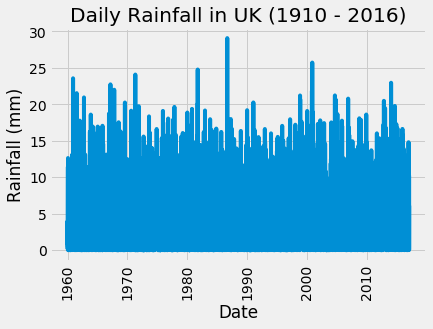

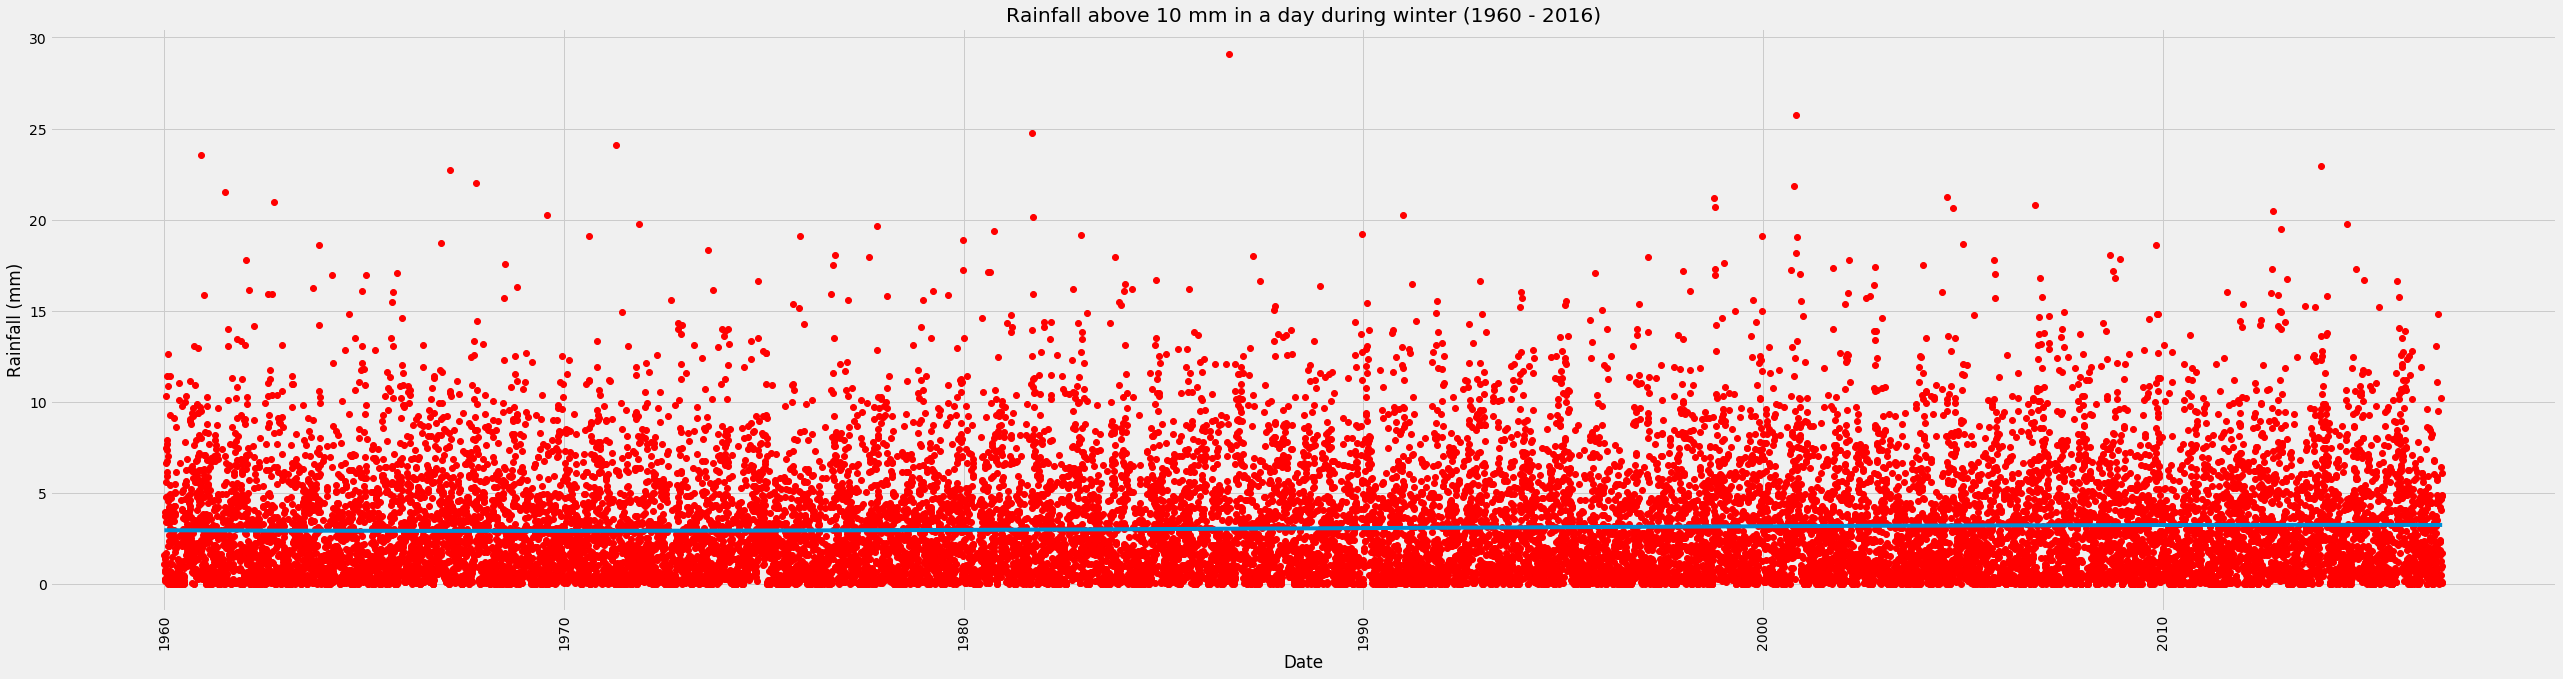

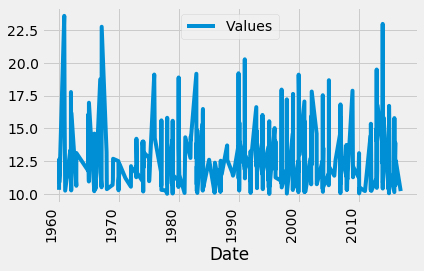

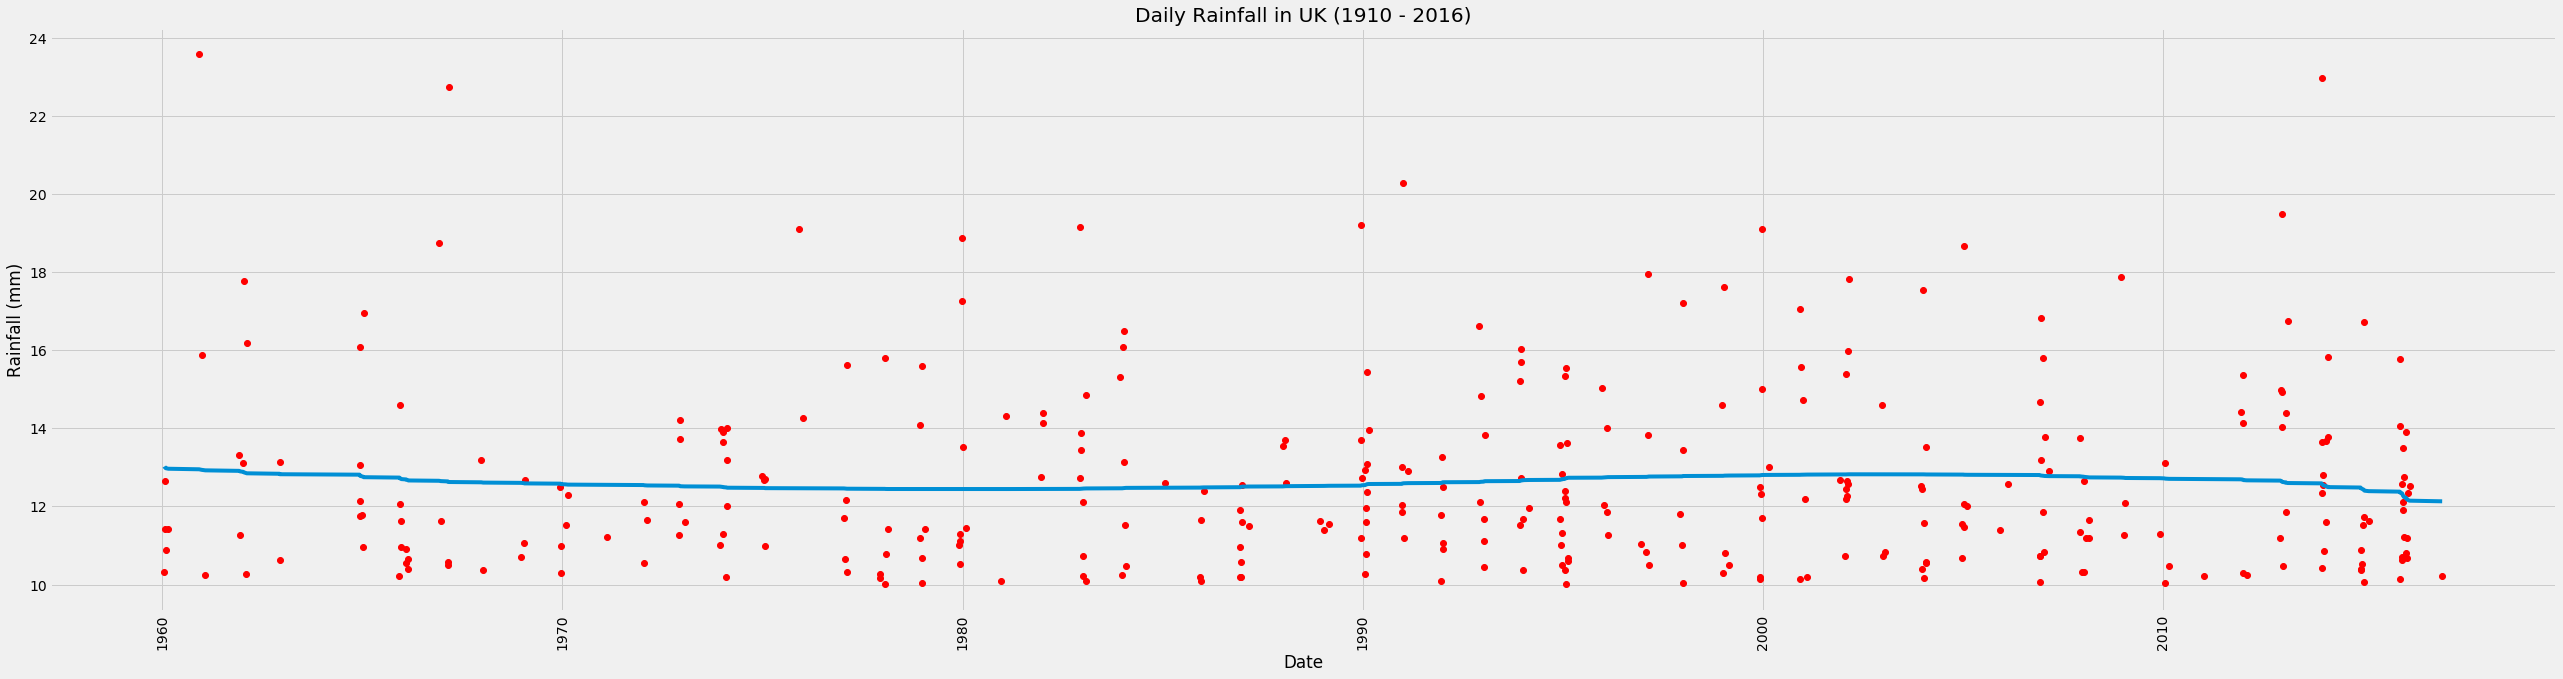

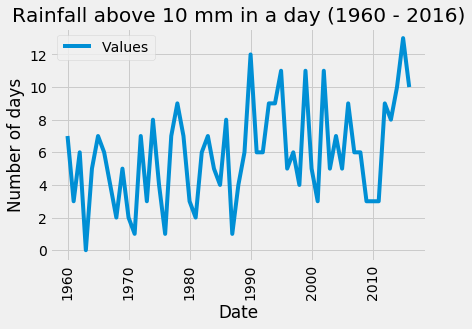

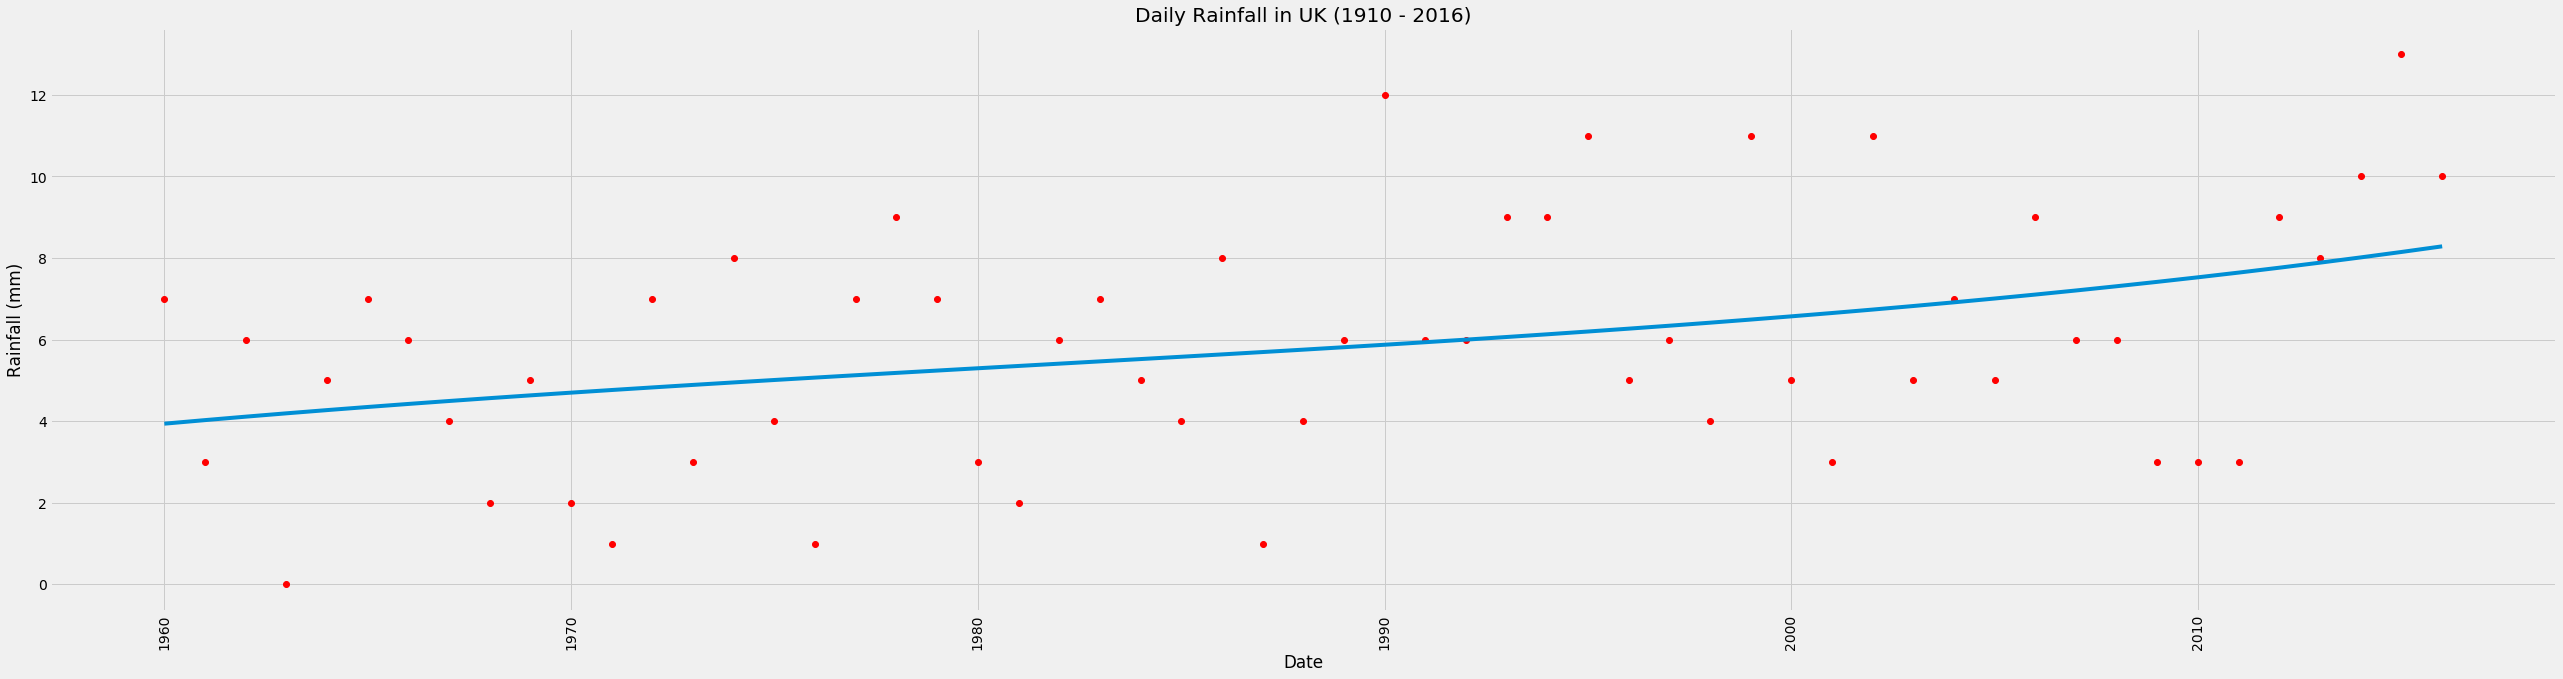

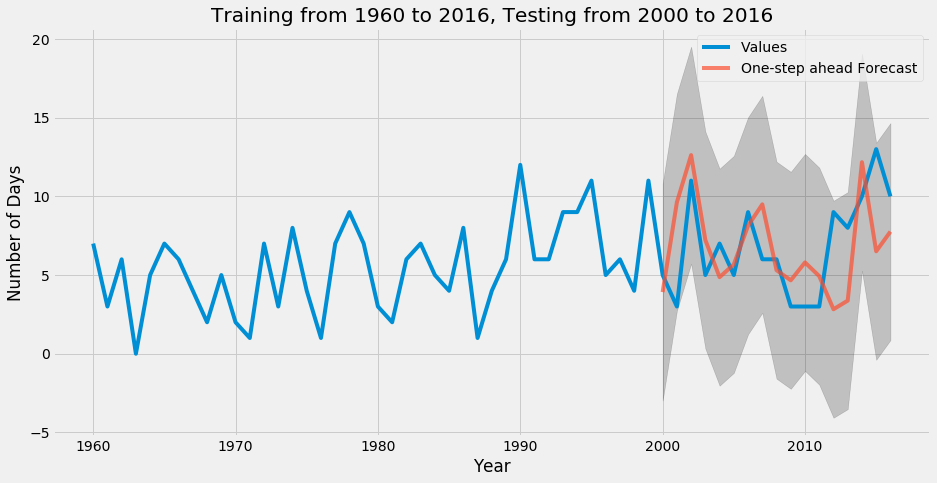

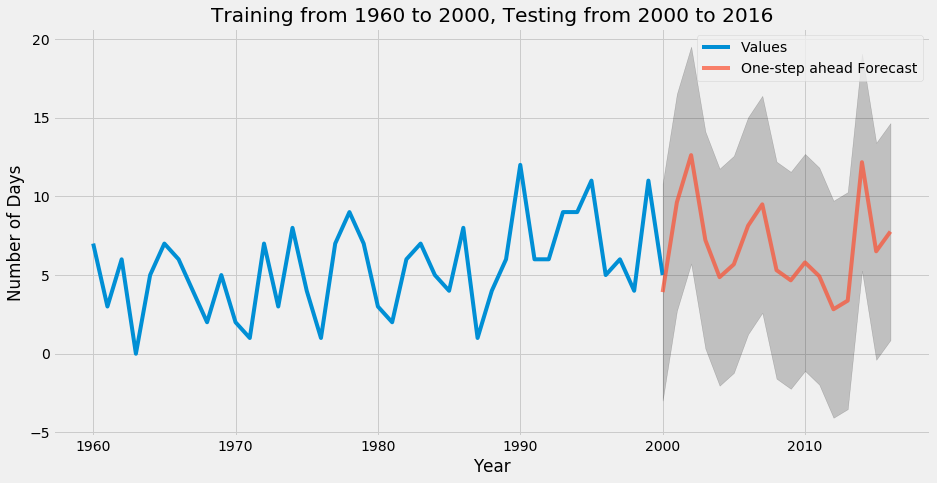

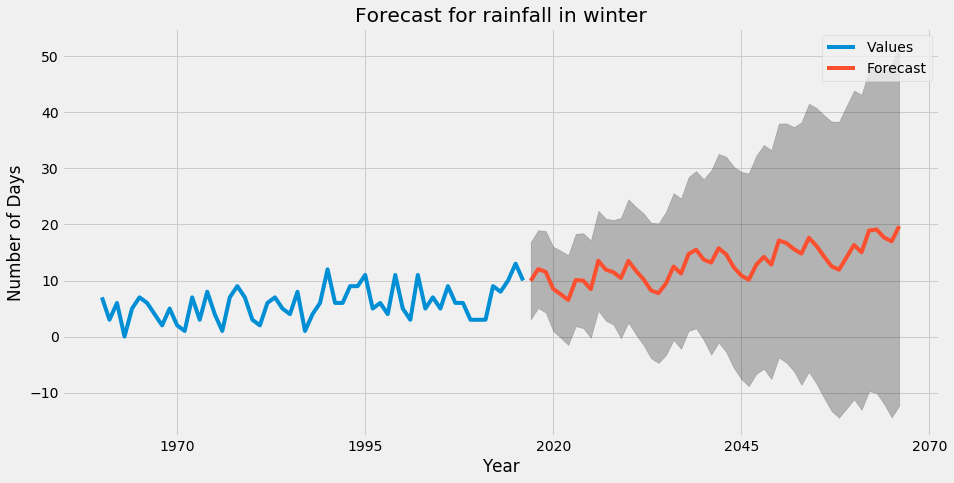

The Root Mean Squared Error of our forecasts is: 3.4020773370658386
CPU times: user 1min 31s, sys: 90.8 ms, total: 1min 31s
Wall time: 4min 9s


In [21]:
%%time 

# WINTER GETTING WETTER

runPredictionDaily("rainfall", "winter")

# RESULT: Correctly Predicted

Number of records (months): 492


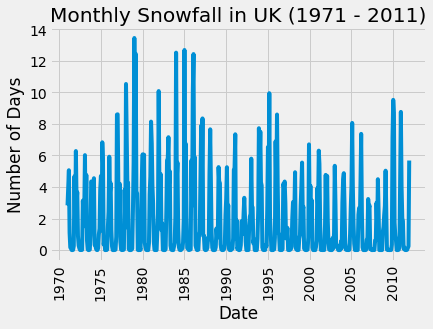

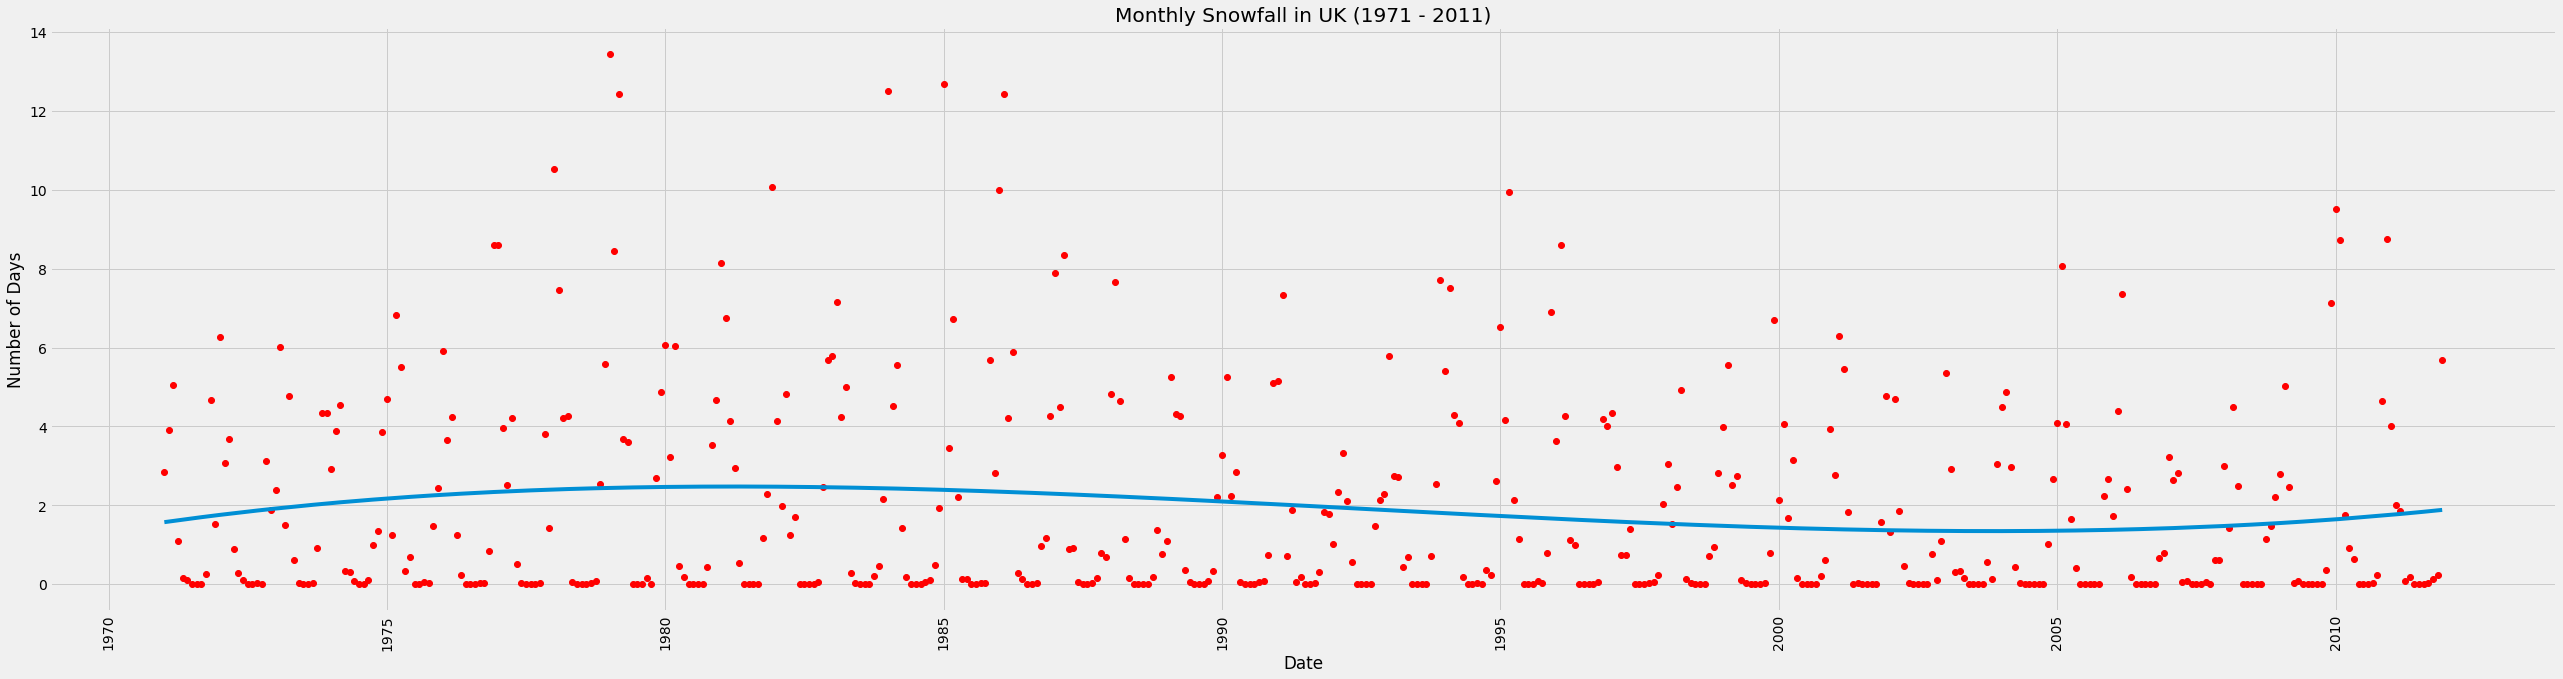

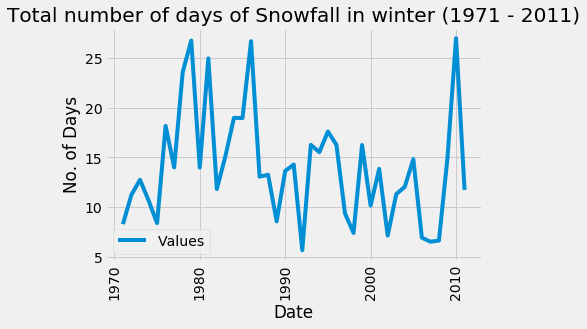

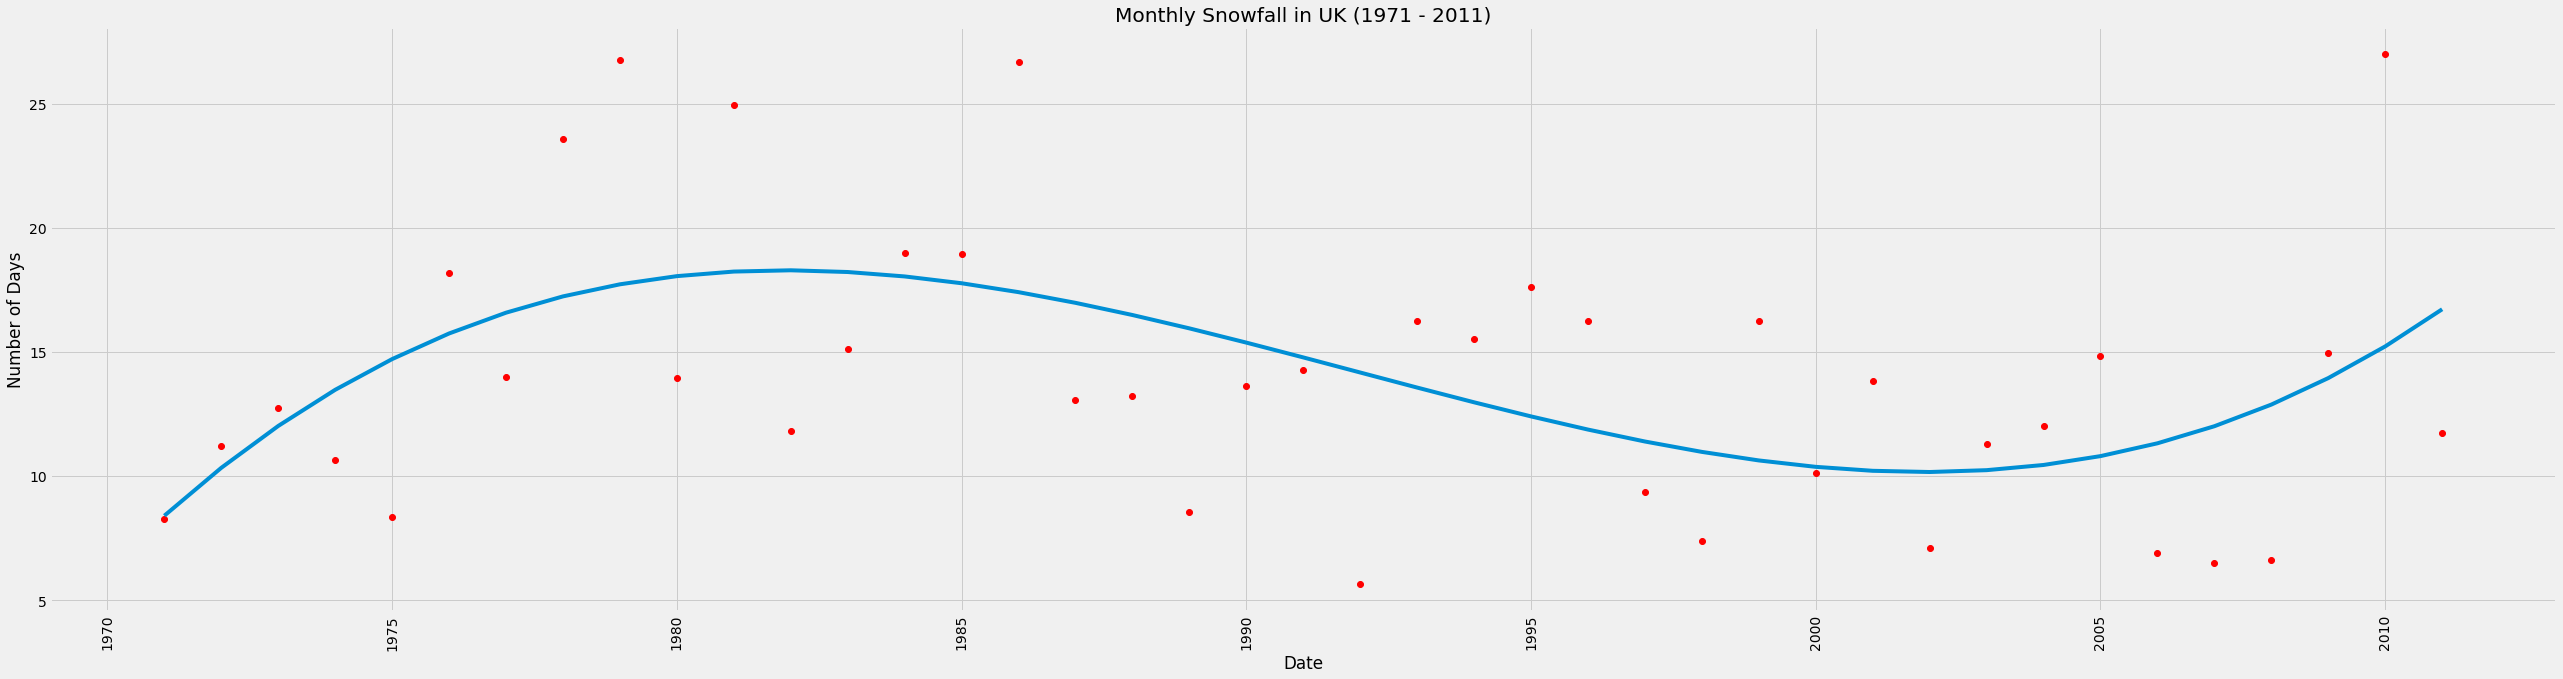

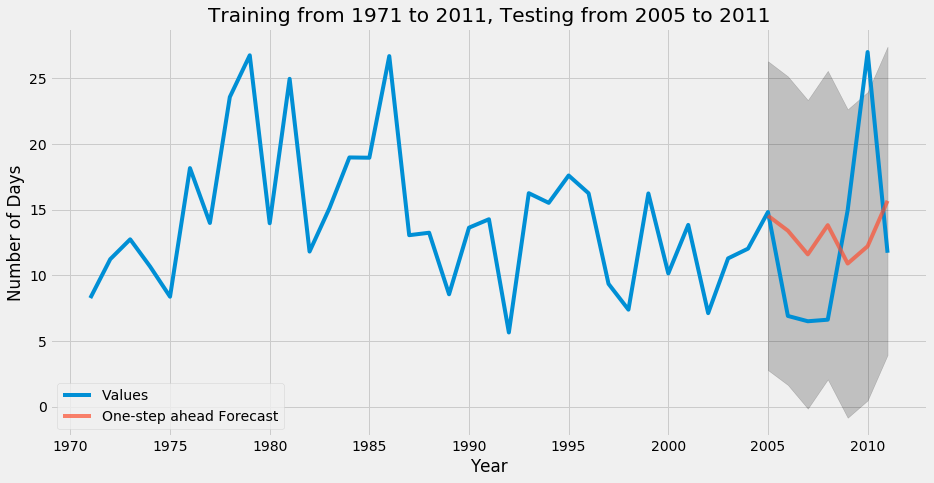

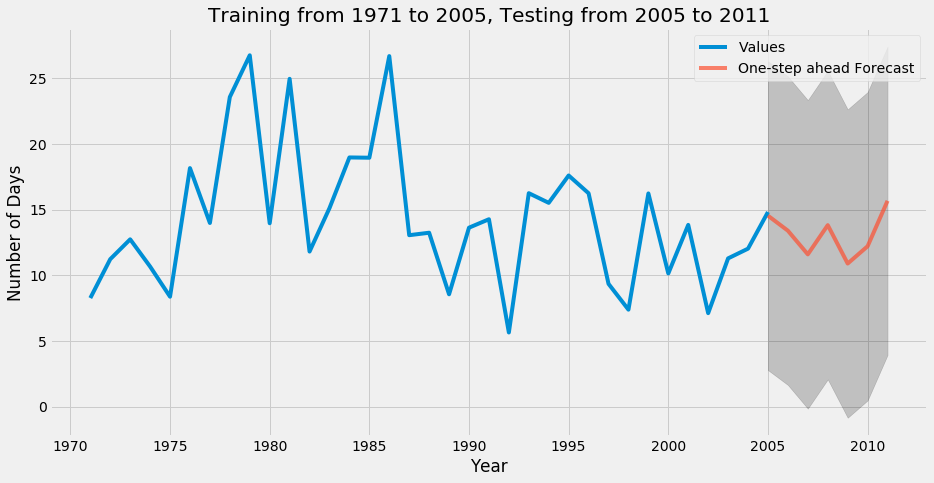

The Root Mean Squared Error of our forecasts is: 7.279756171217336


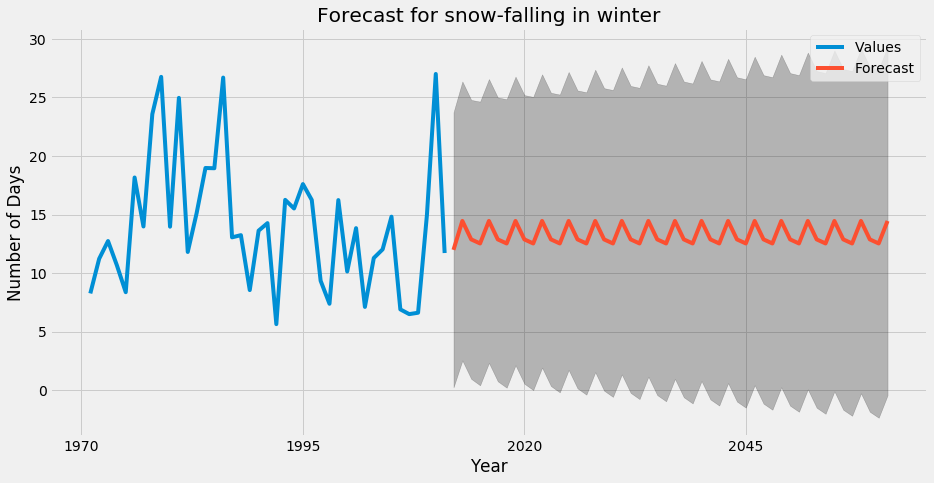

CPU times: user 7.38 s, sys: 68.7 ms, total: 7.45 s
Wall time: 11 s


In [4]:
%%time 

# SNOWFALL DURING WINTER DECREASING

runPredictionMonthly("snow-falling", "winter")

# RESULT : Unpredictable

Number of records (months): 20820


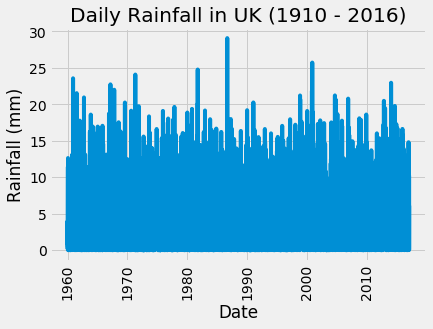

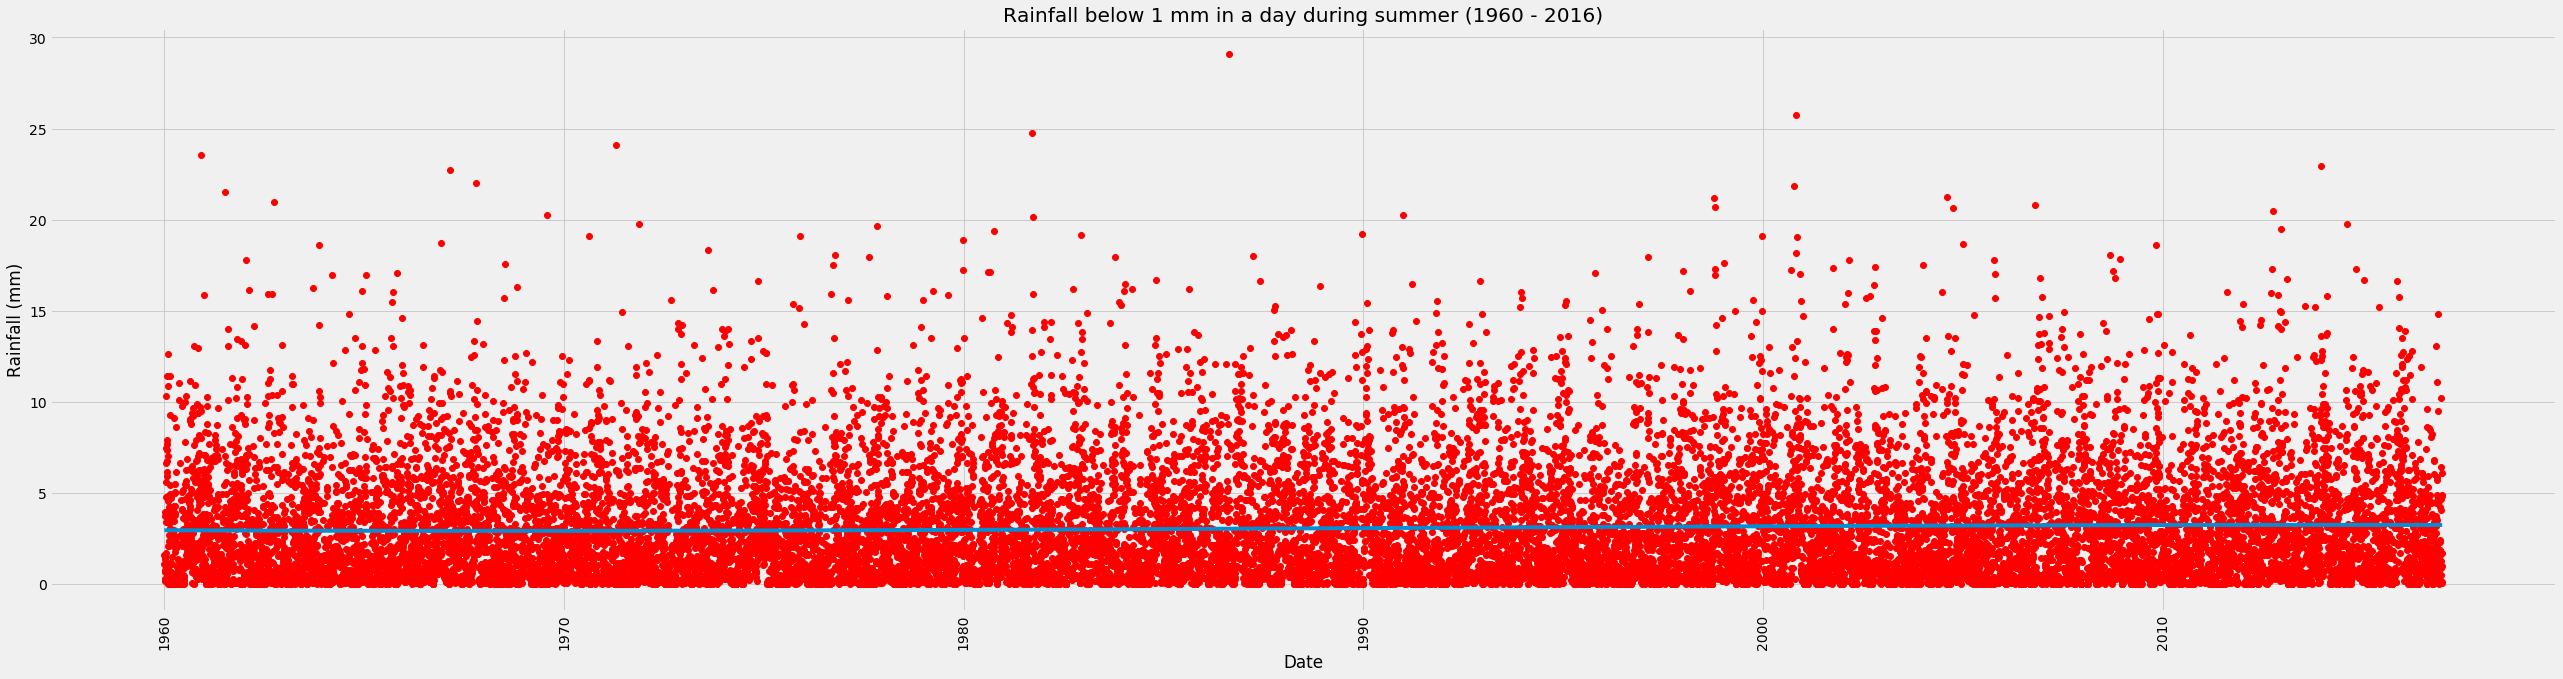

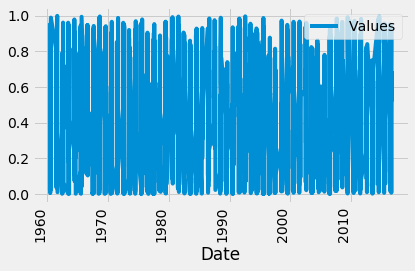

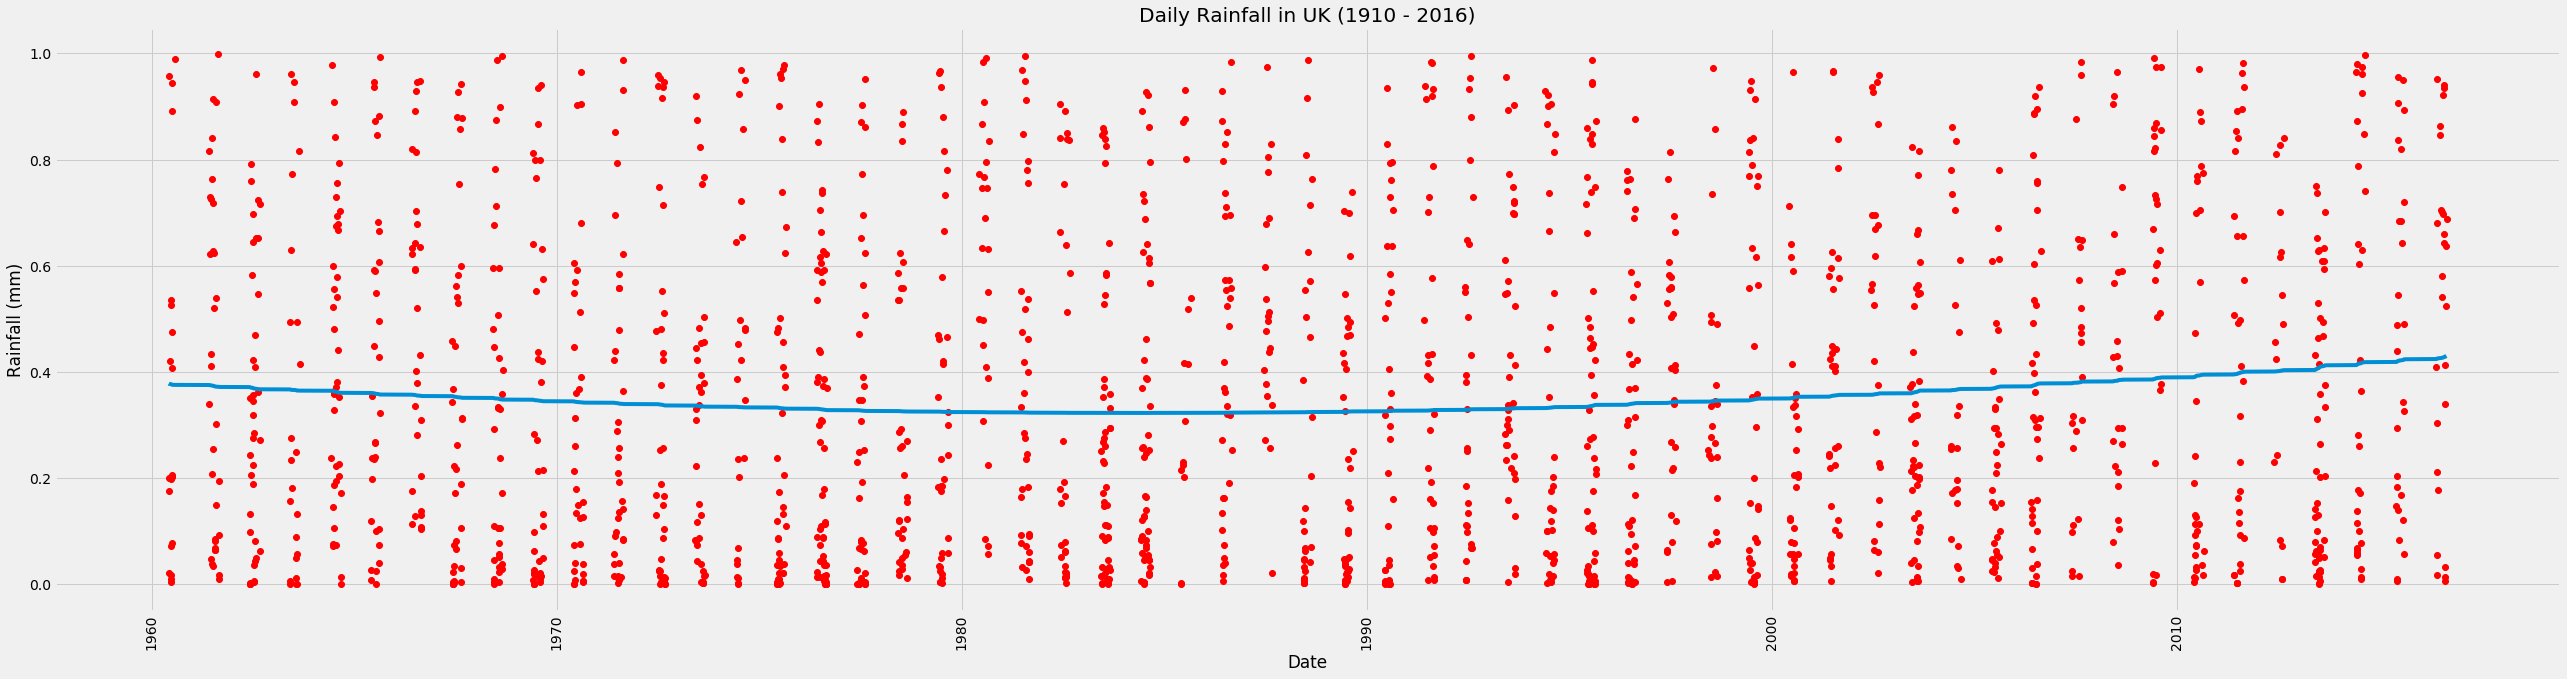

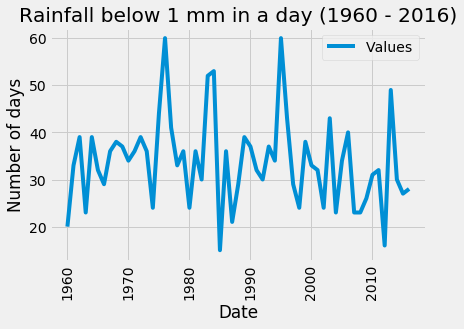

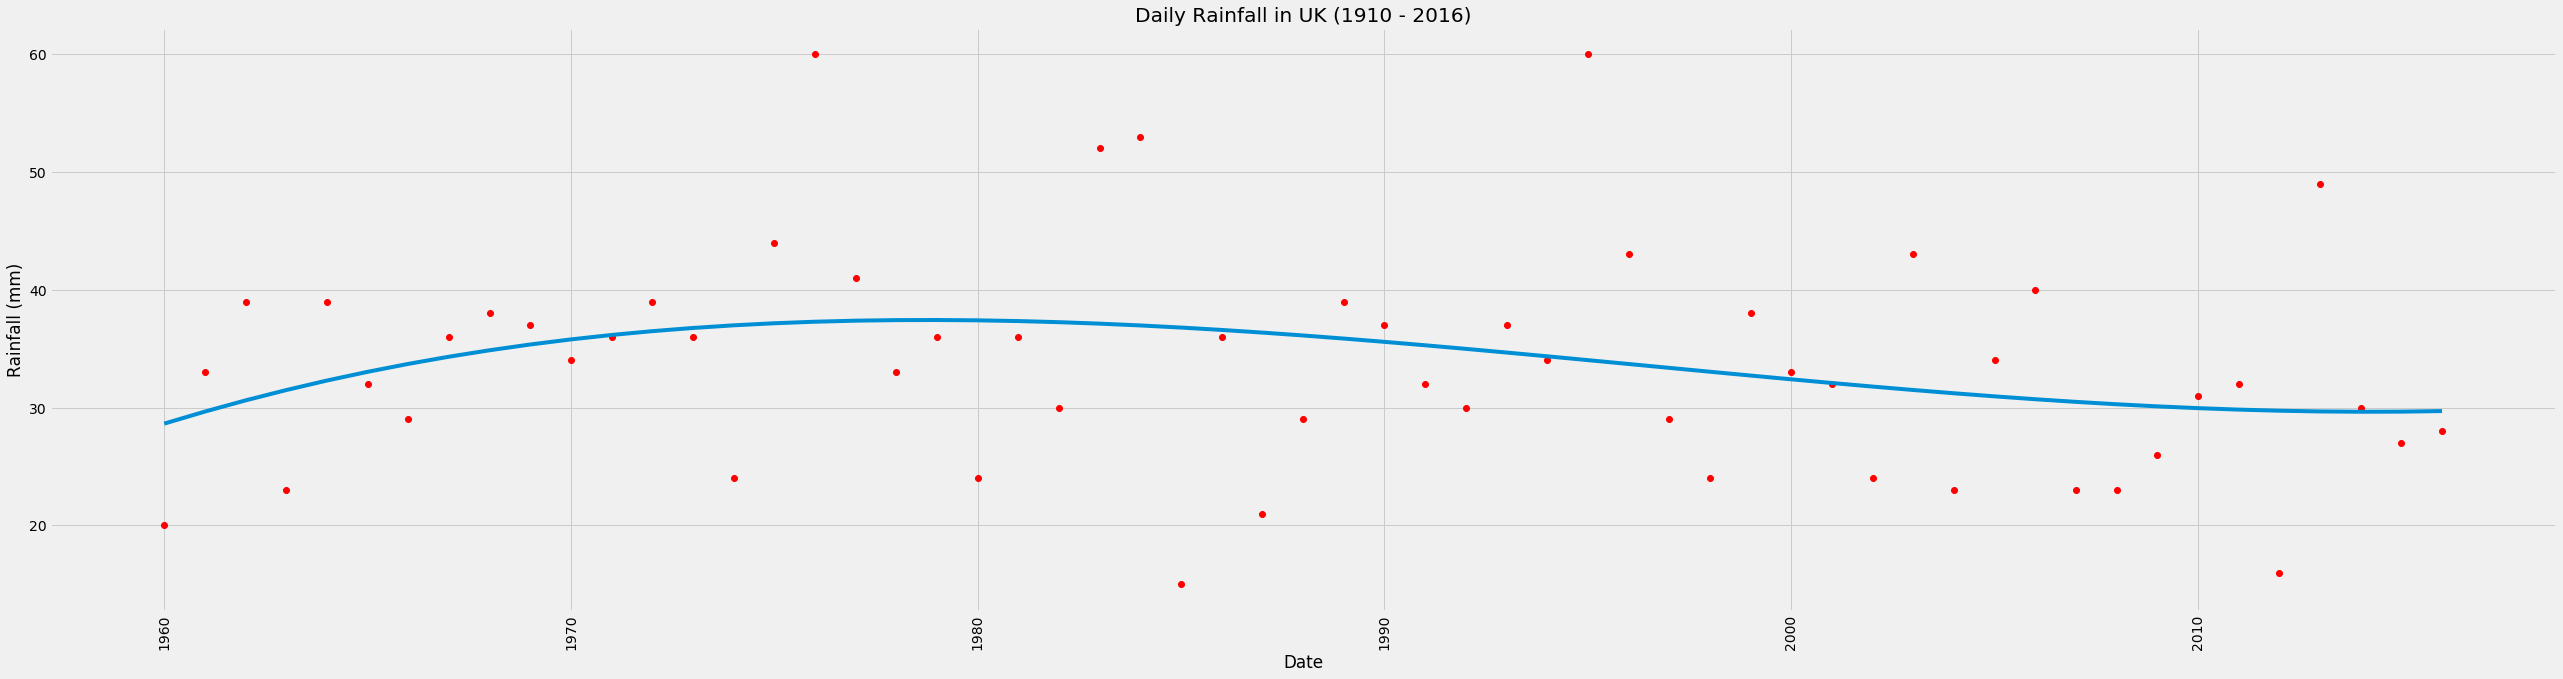

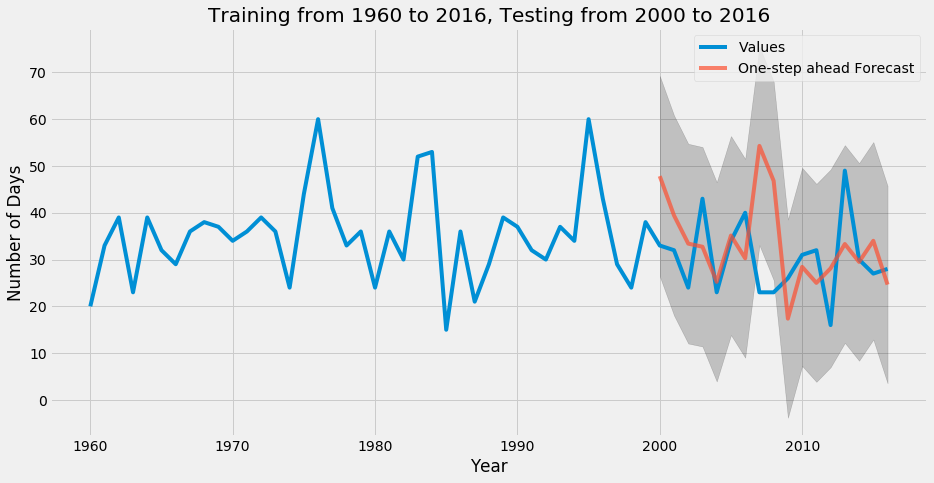

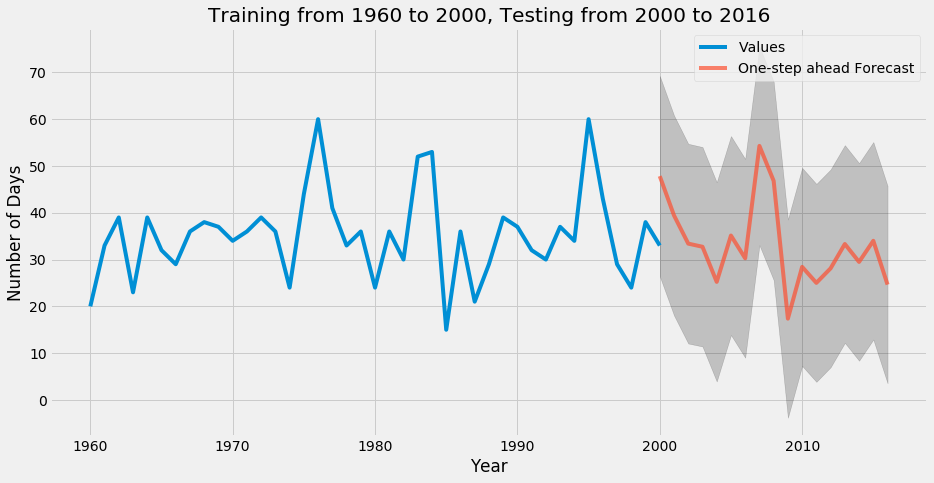

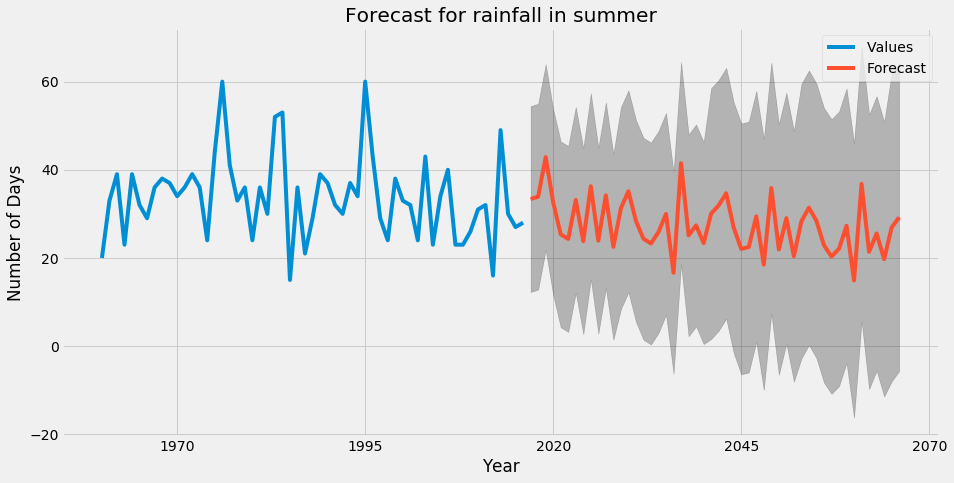

The Root Mean Squared Error of our forecasts is: 12.599831832289574
CPU times: user 1min 31s, sys: 29.1 ms, total: 1min 31s
Wall time: 4min 7s


In [24]:
%%time 

# SUMMER GETTING DRIER

runPredictionDaily("rainfall", "summer")

# Result: Correctly Predicted

Number of records (months): 20820


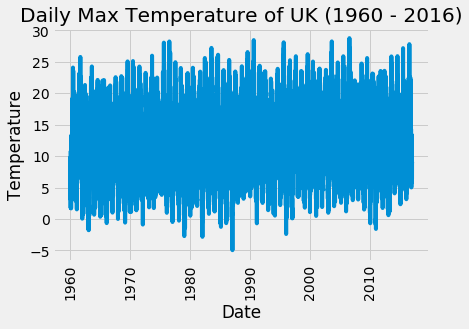

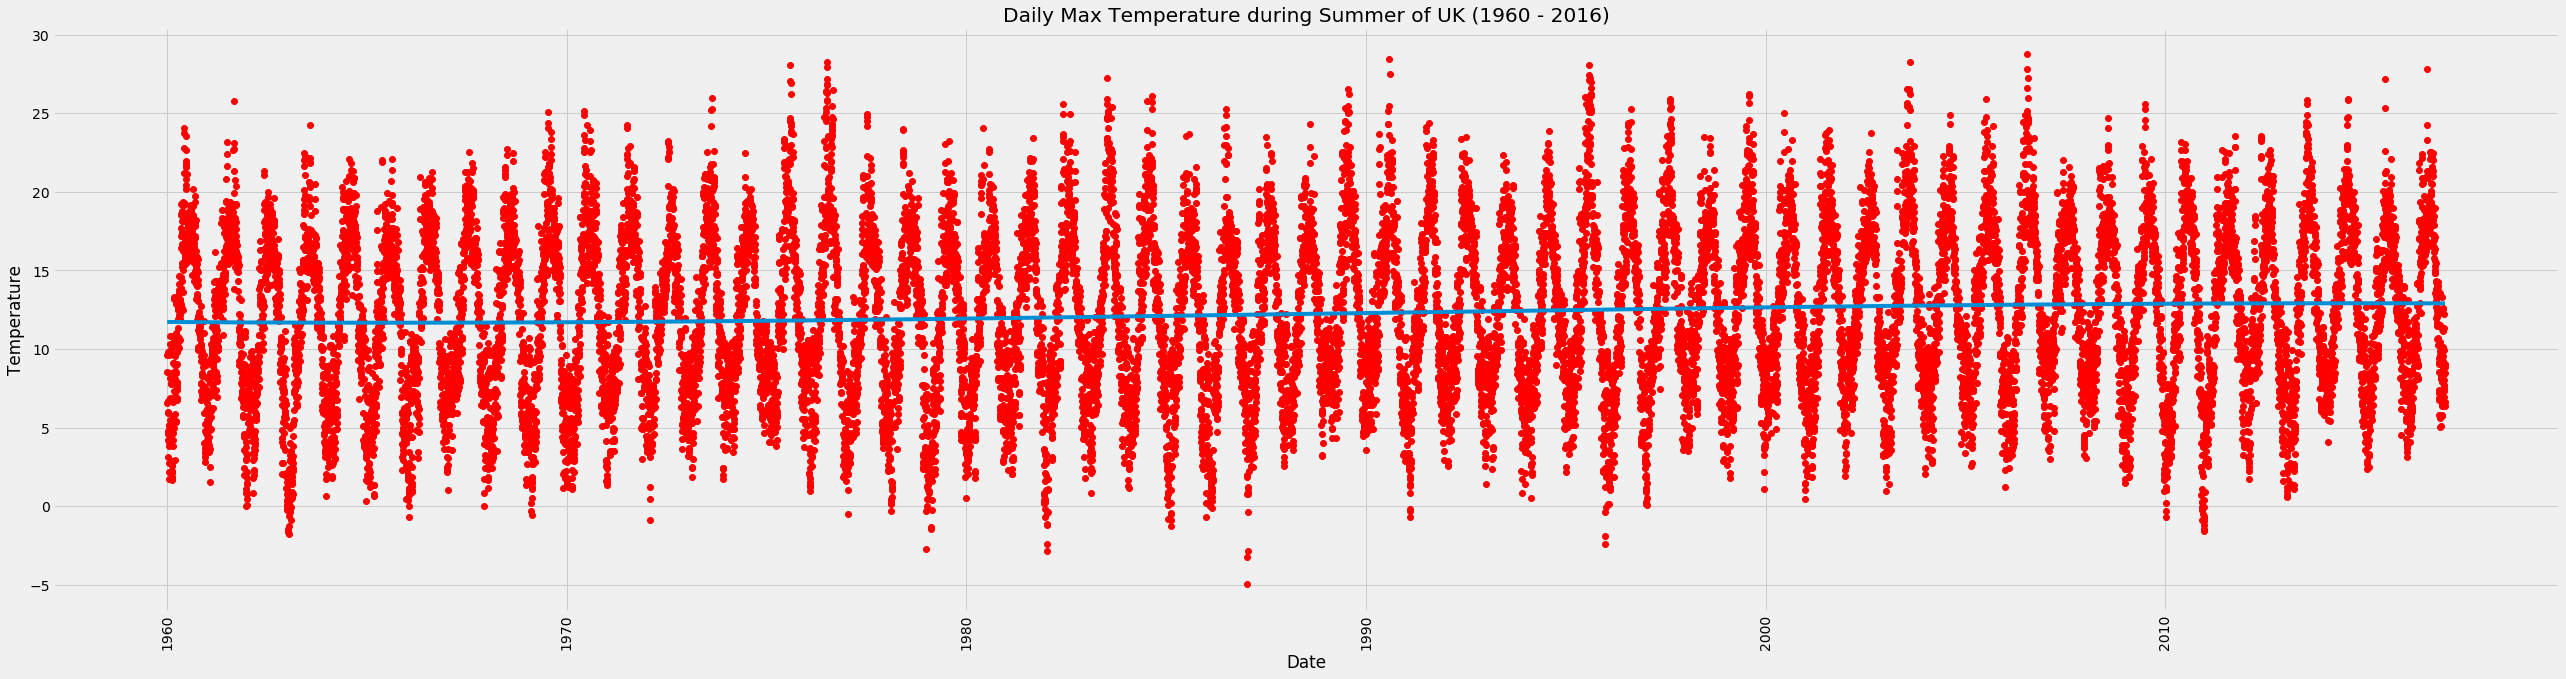

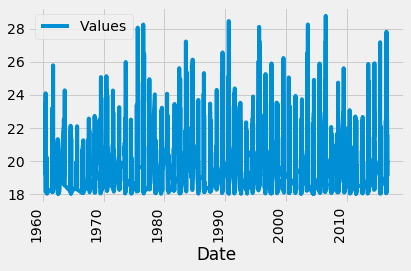

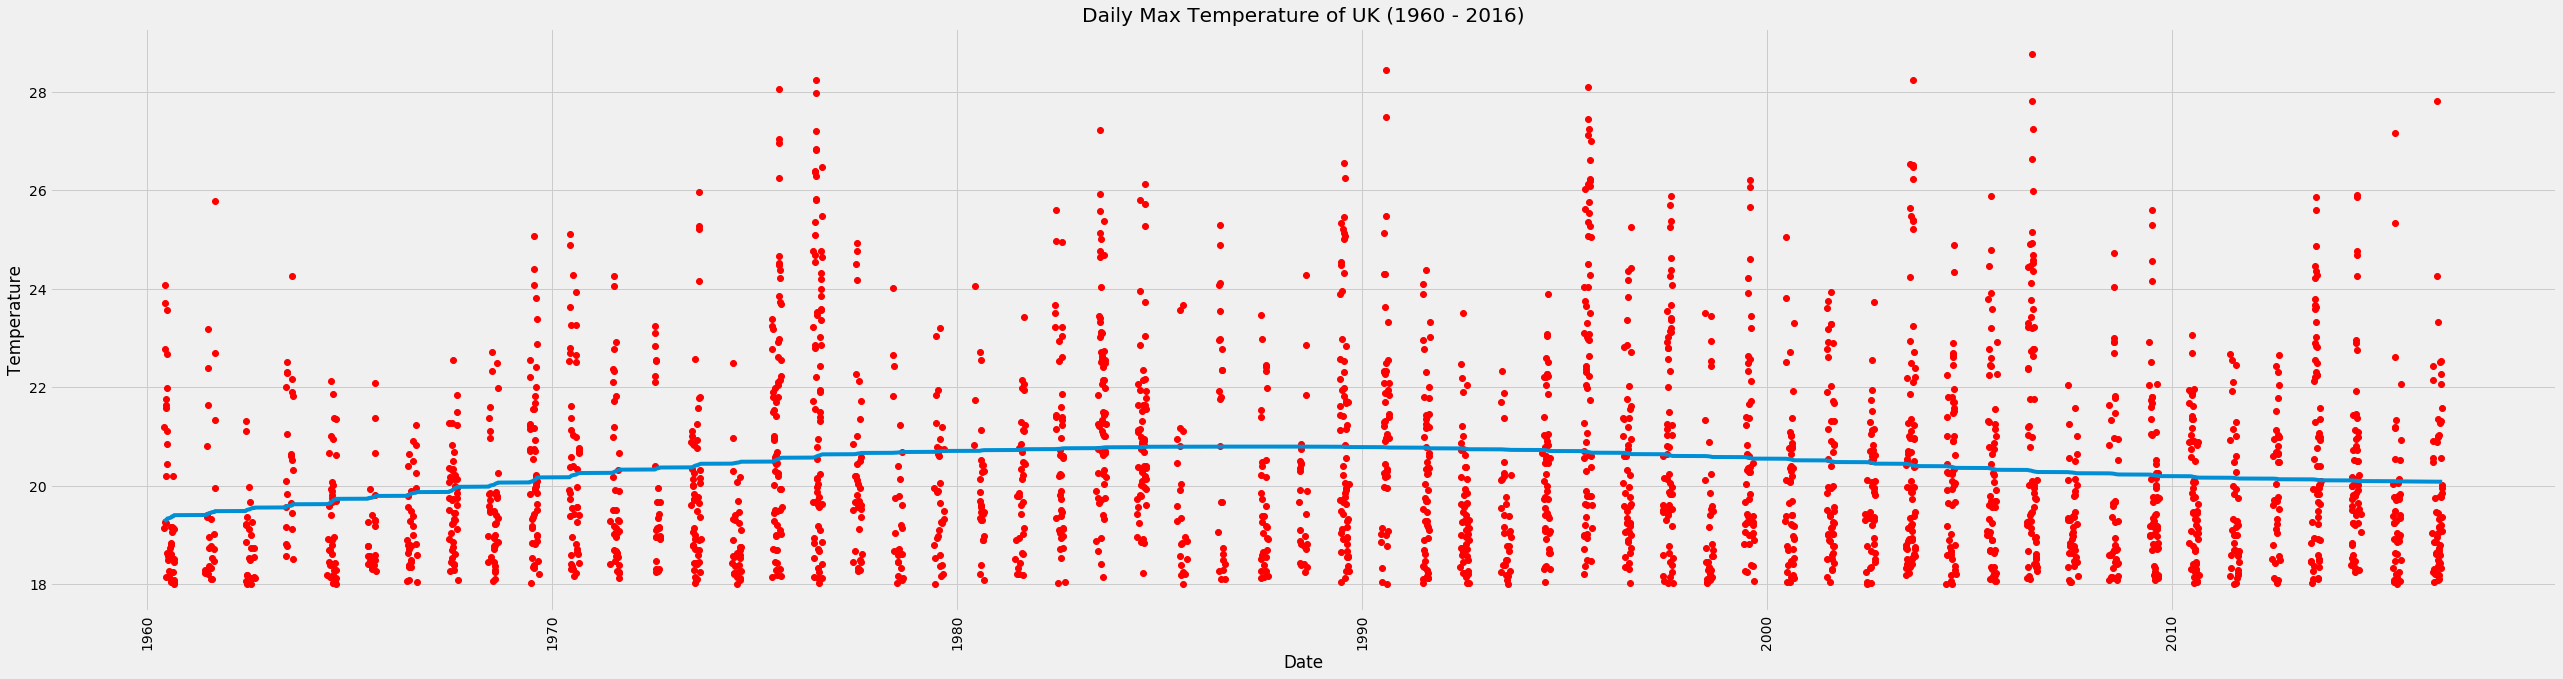

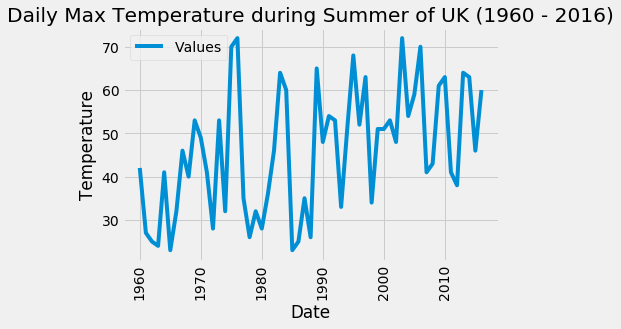

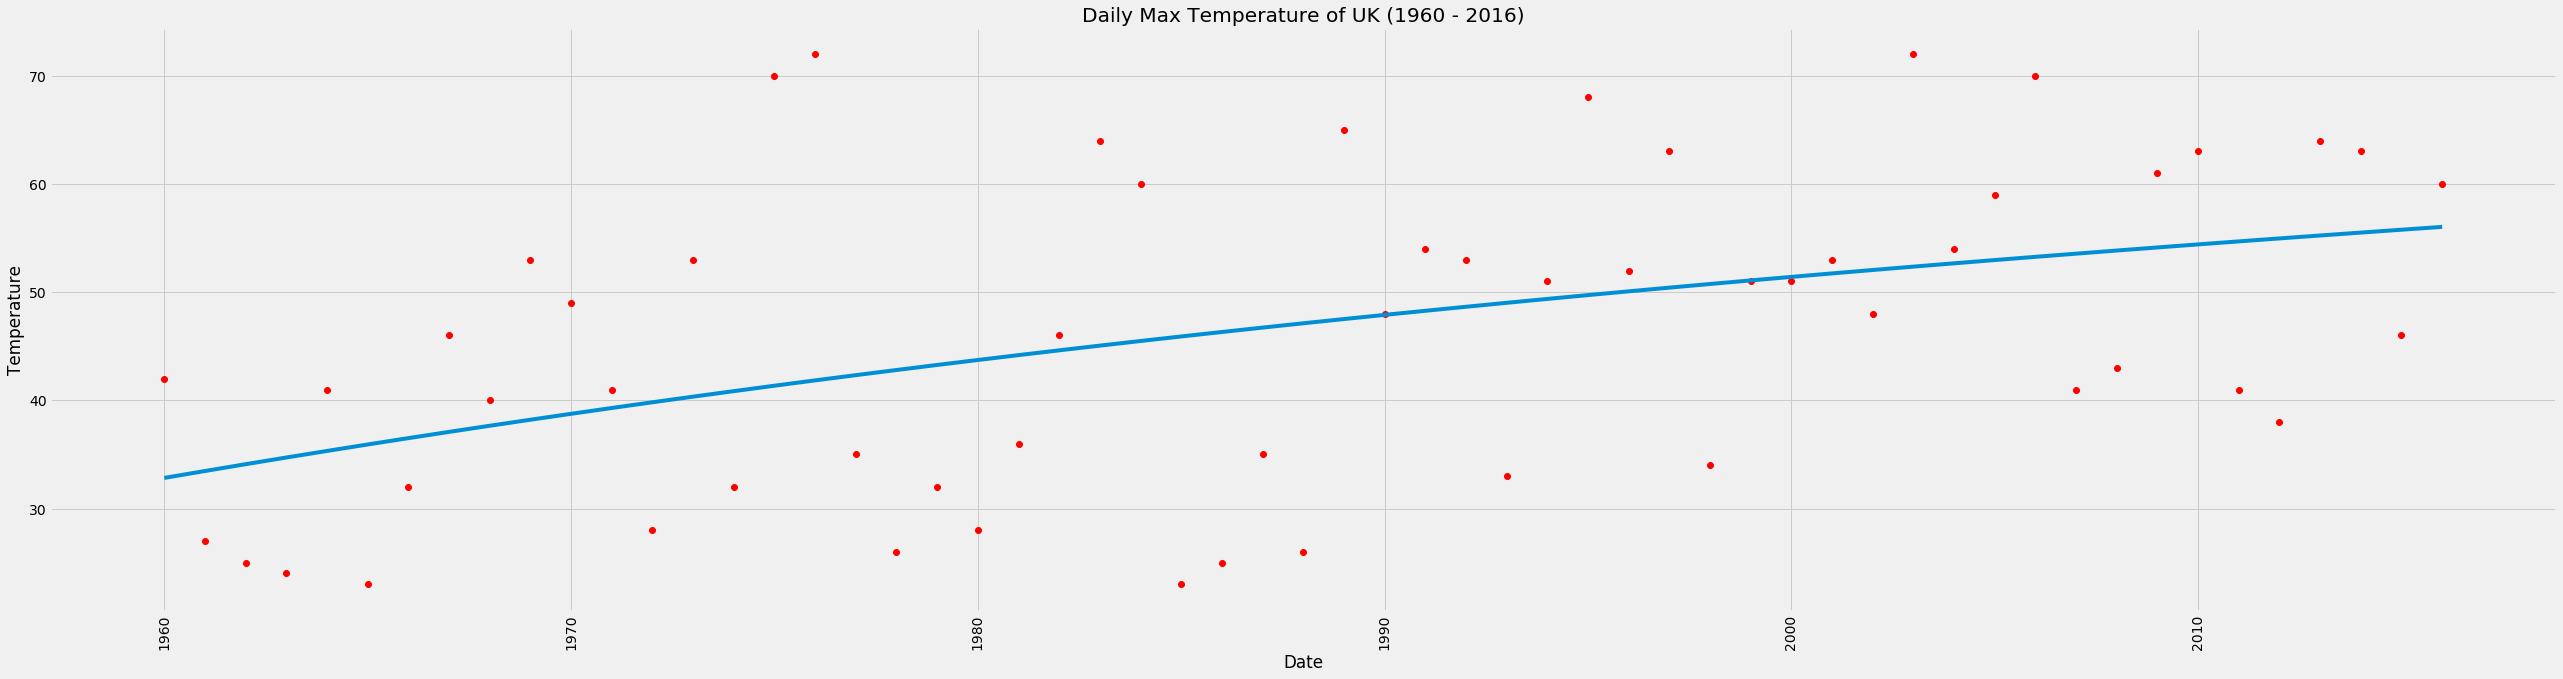

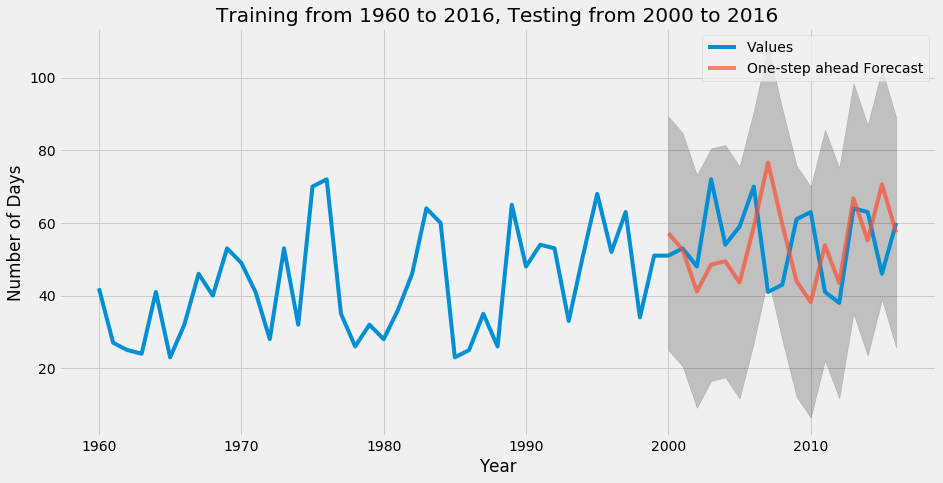

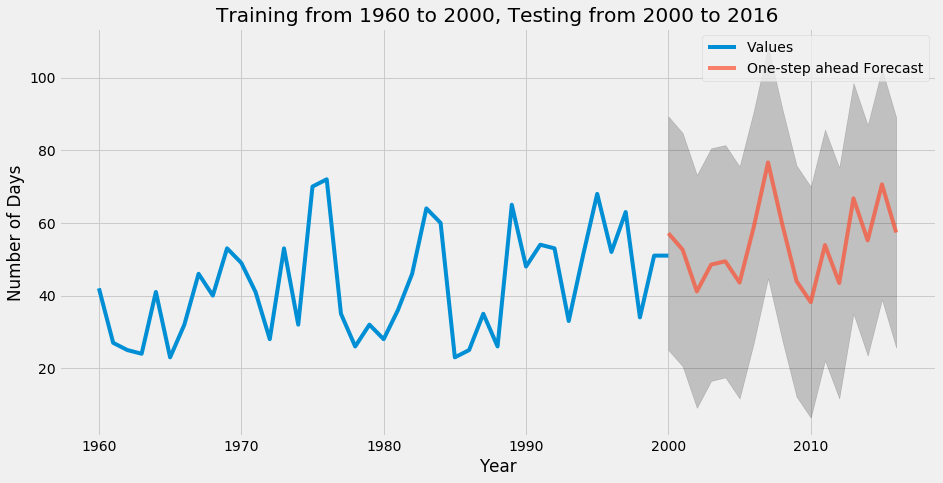

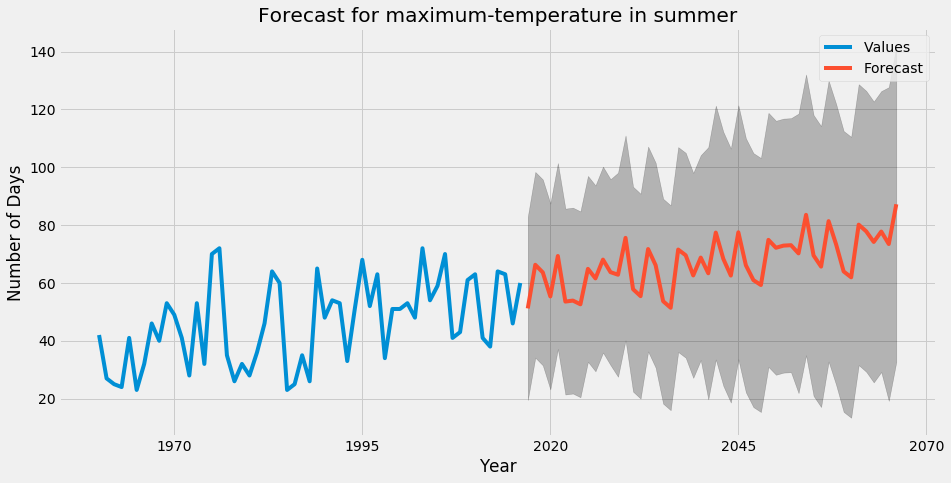

The Root Mean Squared Error of our forecasts is: 15.991771347912797
CPU times: user 1min 35s, sys: 50.9 ms, total: 1min 35s
Wall time: 4min 15s


In [25]:
%%time 

# SUMMER GETTING WARMER

runPredictionDaily("maximum-temperature", "summer")

# Result: Correctly Predicted

Number of records (months): 1056


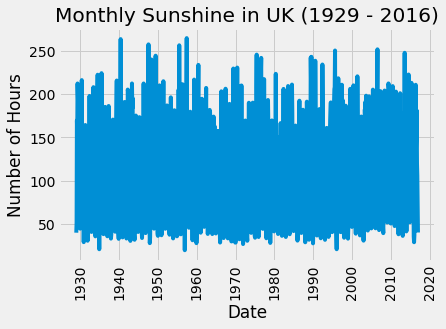

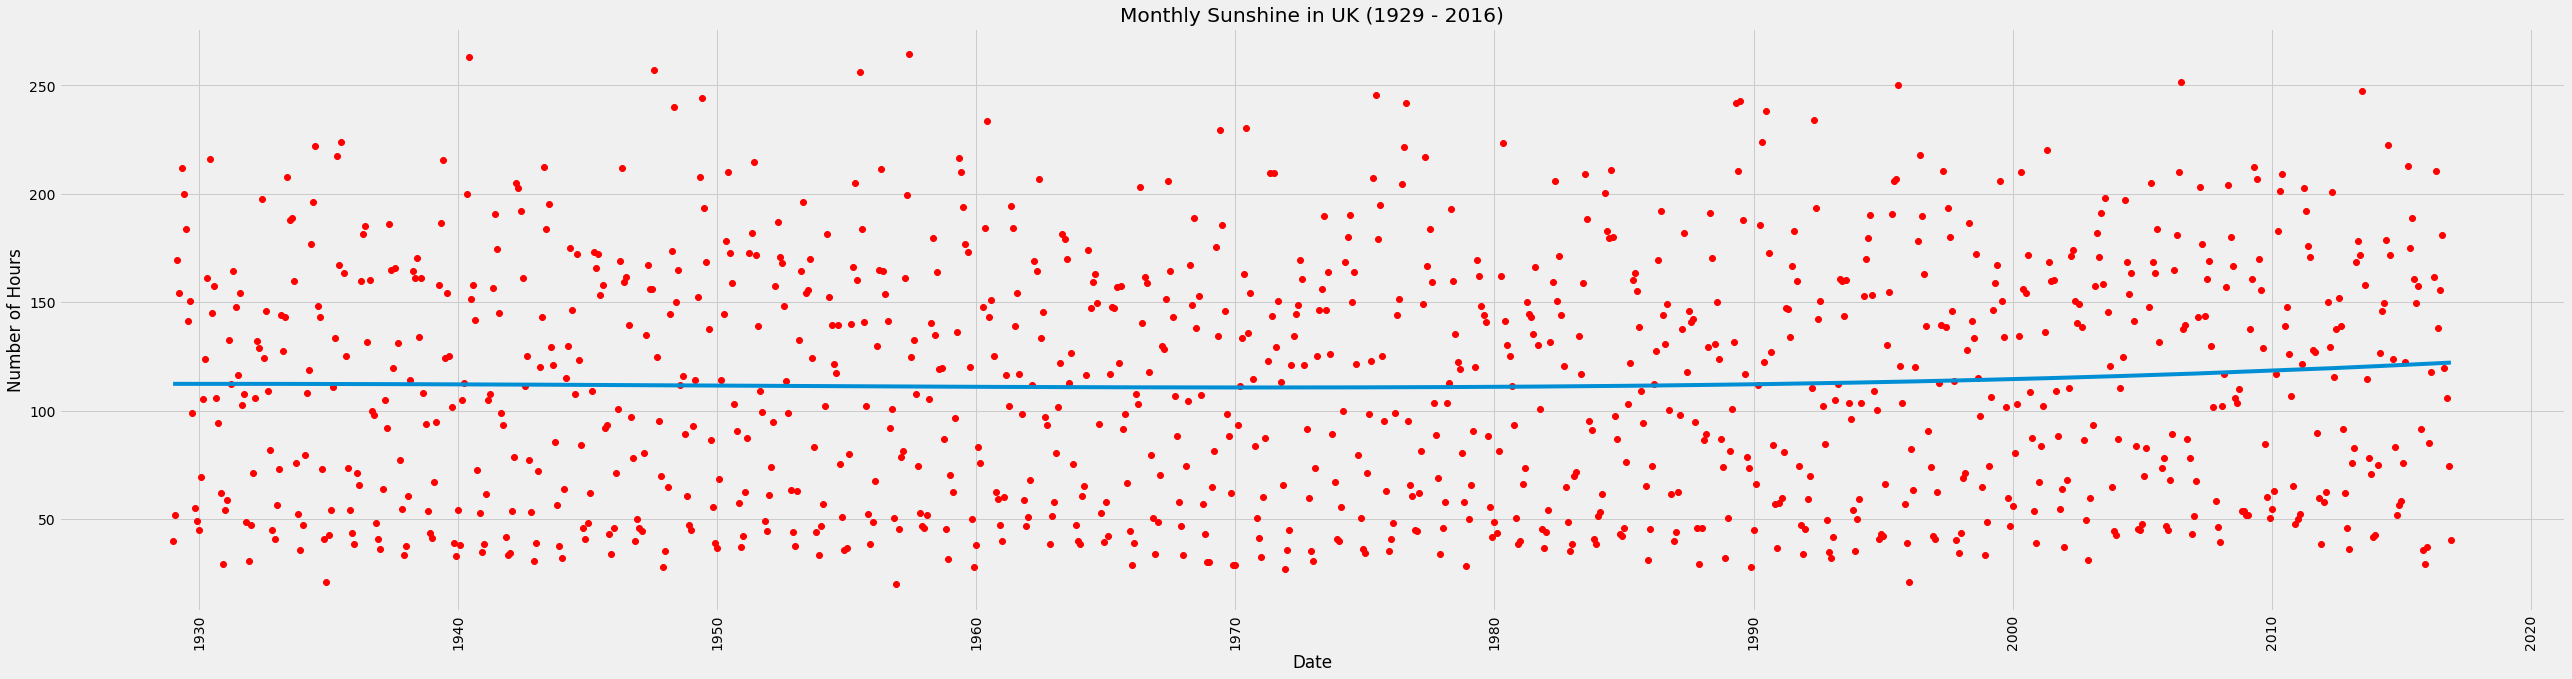

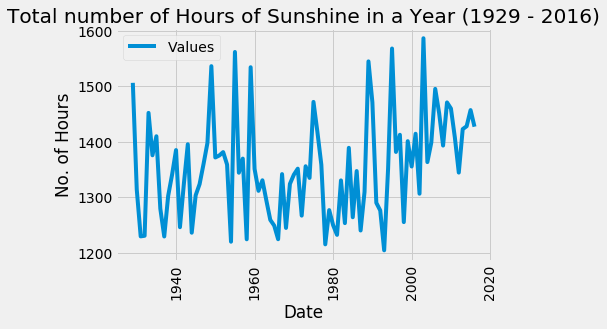

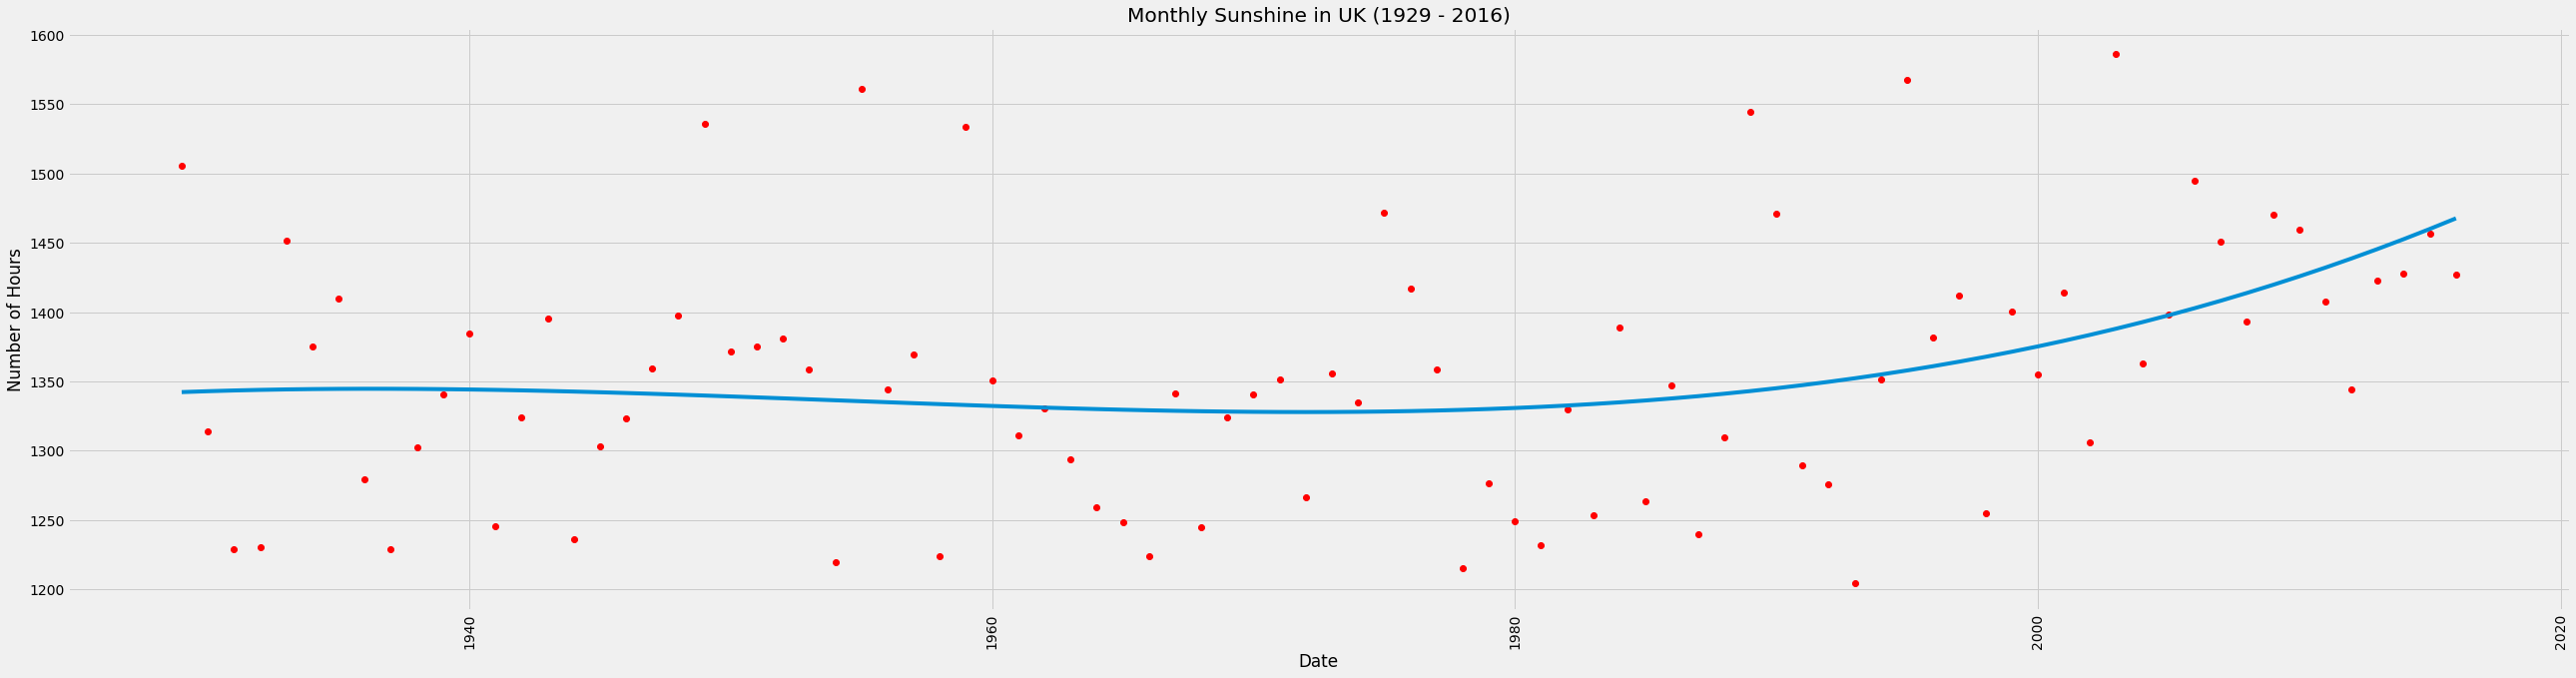

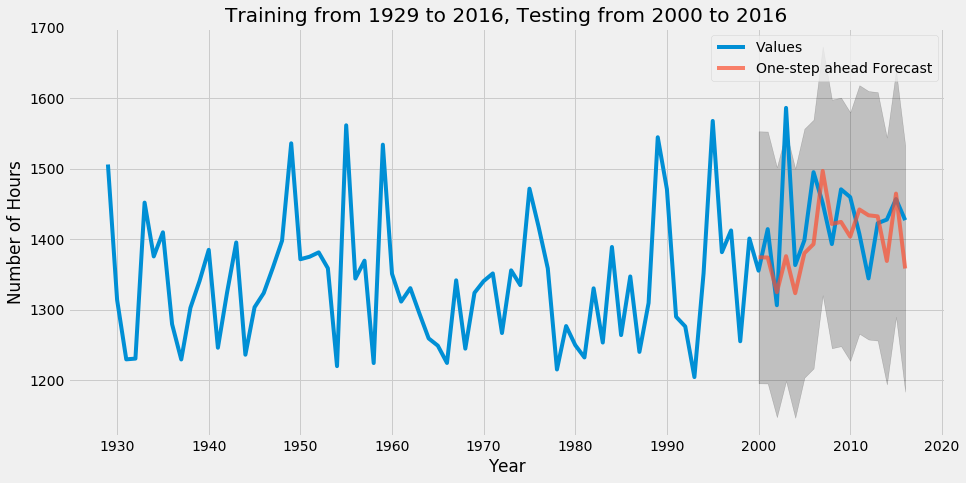

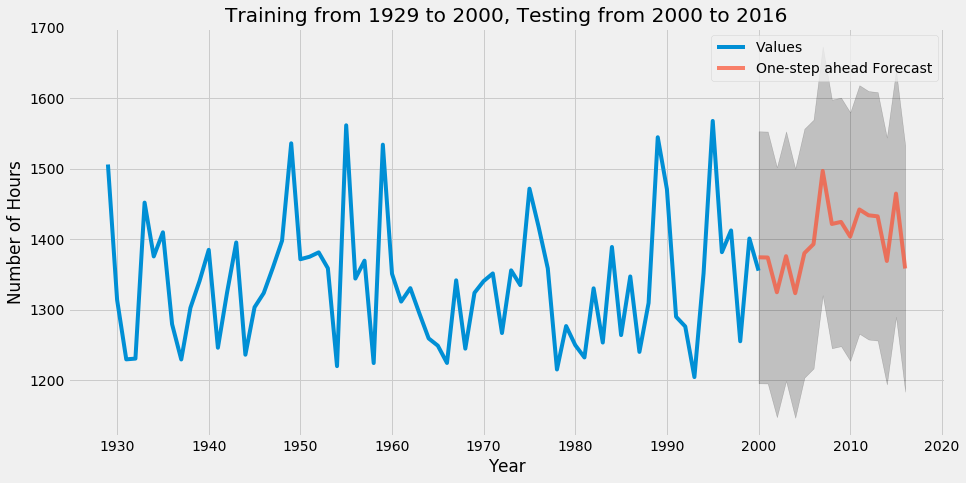

The Root Mean Squared Error of our forecasts is: 70.5609055880208


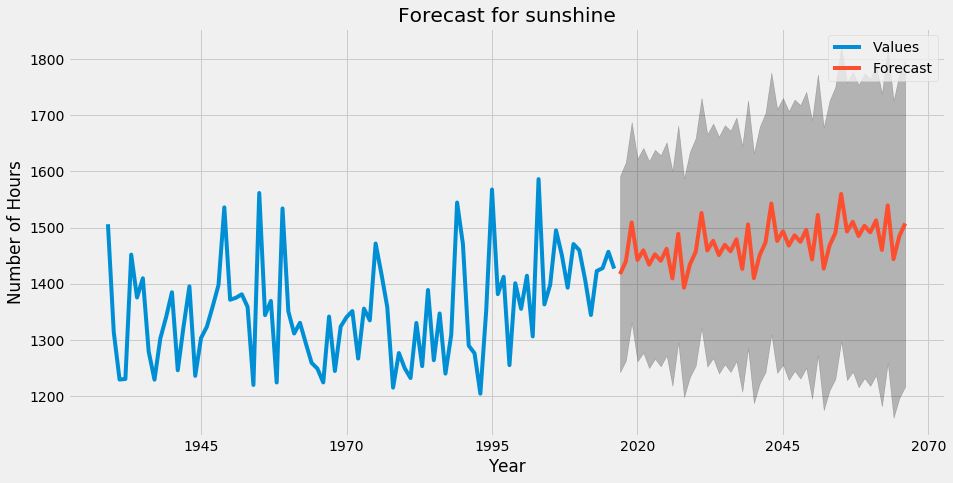

CPU times: user 2min 15s, sys: 84.3 ms, total: 2min 15s
Wall time: 25.7 s


In [5]:
%%time 

# ANNUAL SUNSHINE INCREASING

runPredictionMonthly("sunshine", None)

# Result: Correctly Predicted